In [3]:
import ast
import pickle
import os
import time
import numpy as np
import polychrom

from polychrom import polymerutils
from polychrom import forces
from polychrom import forcekits
from polychrom.simulation import Simulation
from polychrom.starting_conformations import grow_cubic
from polychrom.hdf5_format import HDF5Reporter, list_URIs, load_URI, load_hdf5_file
from polychrom.lib.extrusion import  bondUpdater

import openmm  
import shutil
import warnings
import h5py 
import glob
import sys

#import pyximport; 
#pyximport.install(setup_args={"include_dirs":np.get_include()}, reload_support=True)
from lattice_translocators import LEFTranslocator
from lattice_translocators import LEFTranslocatorDynamicBoundary
import cooltools
import matplotlib.pylab as plt

# Simulation parameters

In [4]:
paramdict = {
    'lifetime':50,
    'separation':10,
    'facestall':0.9,
    'backstall':0.0,
    'stalltime':10,
    'stalloftime':1,
    'stalldist':10,
    'steps':200,
    'velocity_multiplier':1,
    'sites_per_monomer':5,
    'monomer_per_replica':100,
    'replication_number':10
}
N1 = paramdict['monomer_per_replica']   # number of monomers
M = paramdict['replication_number'] # number of replicas of the simulation
N = N1 * M  # total number of monomers
for i in range(len(paramdict)):
        exec("%s_WT=%d"%(str(list(paramdict)[i]).upper(),paramdict[list(paramdict)[i]]))

steps = int(STEPS_WT / VELOCITY_MULTIPLIER_WT)      

# Making Arrays

### LEF arrays

In [5]:
def make_lef_arrays(paramdictx):
    
    N1 = paramdictx['monomer_per_replica']
    Sites_per_monomer = paramdictx['sites_per_monomer']
    Lattice_sites = N1 * Sites_per_monomer
    M = paramdictx['replication_number']
    Separation = paramdictx['separation']
    LEFNum = (N1 * M) // Separation
    LIFETIME_WT = paramdictx['lifetime']
    velocity_multiplier = paramdictx['velocity_multiplier']
    LIFETIME = int(LIFETIME_WT * velocity_multiplier) * Sites_per_monomer 
           
    Array = np.zeros(Lattice_sites, dtype=np.double)
    birthArray = Array + 0.1 
    deathArray = Array + 1. / LIFETIME
    stallDeathArray = Array + 1 / LIFETIME
    pauseArray = Array
        
    return birthArray, deathArray, stallDeathArray, pauseArray, LEFNum

def make_lef_arrays(paramdictx):
    
    N1 = paramdictx['monomer_per_replica']
    Sites_per_monomer = paramdictx['sites_per_monomer']
    Lattice_sites = N1 * Sites_per_monomer
    M = paramdictx['replication_number']
    Separation = paramdictx['separation']
    LEFNum = (N1 * M) // Separation
    LIFETIME_WT = paramdictx['lifetime']
    velocity_multiplier = paramdictx['velocity_multiplier']
    LIFETIME = int(LIFETIME_WT * velocity_multiplier) * Sites_per_monomer 
           
    Array = np.zeros(Lattice_sites, dtype=np.double)
    birthArray = Array +0.000000
    birthArray[Lattice_sites//3+4] = 0.1
    deathArray = Array + 1. / LIFETIME
    stallDeathArray = Array + 1 / LIFETIME
    pauseArray = Array
        
    return birthArray, deathArray, stallDeathArray, pauseArray, LEFNum

### STALL Arrays

In [6]:
def make_stall_array(paramdictx, RightstallList, LeftstallList):
    
    N1 = paramdictx['monomer_per_replica']
    Sites_per_monomer = paramdictx['sites_per_monomer']
    Lattice_sites = N1 * Sites_per_monomer
    velocity_multiplier = paramdictx['velocity_multiplier']
    Facestall_wt = paramdictx['facestall']
    Backstall_wt = paramdictx['backstall']  
    Facestall =   1 - (1 - (Facestall_wt))**( 1/velocity_multiplier)
    Backstall =   1 - (1 - (Backstall_wt))**( 1/velocity_multiplier) 

    Array = np.zeros(Lattice_sites, dtype=np.double)
    stallRight = np.zeros(Lattice_sites, dtype=np.double)
    stallLeft = np.zeros(Lattice_sites, dtype=np.double)
    stallRight_c = np.zeros(Lattice_sites, dtype=np.double)
    stallLeft_c = np.zeros(Lattice_sites, dtype=np.double)
    
    for i in RightstallList:
        stallRight[i] = Facestall
        stallLeft[i] = Backstall

    for j in LeftstallList:
        stallRight_c[j] = Backstall
        stallLeft_c[j] = Facestall
        
    stallRightArray = stallRight + stallRight_c
    stallLeftArray = stallLeft + stallLeft_c
    
    return stallRightArray, stallLeftArray

### Translocation Arrays

In [9]:
def make_translocator(paramdictx, RightstallList, LeftstallList):
    
    N1 = paramdictx['monomer_per_replica']
    M = paramdictx['replication_number']
    SEPARATION = paramdictx['separation']
    Stalltime_WT = paramdictx['stalltime']
    Stalloftime_WT = paramdictx['stalloftime']
    Sites_per_monomer = paramdictx['sites_per_monomer']
    velocity_multiplier = paramdictx['velocity_multiplier']
    stalltime = Stalltime_WT * velocity_multiplier * Sites_per_monomer
    stalloftime = Stalloftime_WT * velocity_multiplier * Sites_per_monomer
    
    birthArray, deathArray, stallDeathArray, pauseArray, LEFNum = make_lef_arrays(paramdictx)
    stallRightArray, stallLeftArray = make_stall_array(paramdictx, RightstallList, LeftstallList) 
    LEFTran = LEFTranslocatorDynamicBoundary(
        np.tile(birthArray,M), 
        np.tile(deathArray,M),
        np.tile(stallLeftArray,M),
        np.tile(stallRightArray,M),
        np.tile(pauseArray,M),
        np.tile(stallDeathArray,M),
        stalltime, 
        stalloftime,
        LEFNum)
    return LEFTran, LEFNum

### testing arrays

In [10]:
paramdict1 = {
    'lifetime':10,
    'separation':10,
    'facestall':0.9,
    'backstall':0.0,
    'stalltime':1000,
    'stalloftime':1,
    'stalldist':10,
    'steps':200,
    'velocity_multiplier':1,
    'sites_per_monomer':5,
    'monomer_per_replica':10,
    'replication_number':10
}

Lattice_sites1 = paramdict1['monomer_per_replica'] * paramdict1['sites_per_monomer']
RightstallList1 = [i for i in range(0, Lattice_sites1, 50)]
LeftstallList1 = [k for k in range(10, Lattice_sites1, 50)]
Stalldist = STALLDIST_WT * SITES_PER_MONOMER_WT 
l, lefnum = make_translocator(paramdict1, RightstallList1, LeftstallList1)
num_lefs1 = len(l.getLEFs()[1])
print(len(l.getLEFs()[1]))

paramdict5 = {
    'lifetime':30,
    'separation':10,
    'facestall':0.9,
    'backstall':0.0,
    'stalltime':1000,
    'stalloftime':1,
    'stalldist':10,
    'steps':200,
    'velocity_multiplier':1,
    'sites_per_monomer':5,
    'monomer_per_replica':10,
    'replication_number':10
}

Lattice_sites5 = paramdict5['monomer_per_replica'] * paramdict5['sites_per_monomer']
RightstallList5 = [i for i in range(0, Lattice_sites5, 50)]
LeftstallList5 = [k for k in range(10, Lattice_sites5, 50)]
l, lefnum = make_translocator(paramdict5, RightstallList5, LeftstallList5)
num_lefs5 = len(l.getLEFs()[1])
print(len(l.getLEFs()[1]))

### testing lef number
assert num_lefs1 == num_lefs5


### testing processivity
dists1=[]
dists5=[]
TRAJ_LEN = 100
for j in range(10):
    l, lefnum = make_translocator(paramdict1, RightstallList1, LeftstallList1)
    l.steps(TRAJ_LEN)
    lefs1 = l.getLEFs()
    avg_dist_1 = np.mean(lefs1[1]-lefs1[0])
    dists1.append(avg_dist_1)
    

    l, lefnum = make_translocator(paramdict5, RightstallList5, LeftstallList5)
    l.steps(TRAJ_LEN * paramdict['sites_per_monomer'])
    lefs5 = l.getLEFs()
    avg_dist_5 = np.mean( lefs5[1]-lefs5[0])
    dists5.append(avg_dist_5)
print(np.mean(dists1), np.mean(dists5))

10
10
29.96 38.09000000000001


### file name

In [8]:
def paramdict_to_filename(paramdictx):
    
    filename='file'
    for i in range(len(paramdictx)):
        filename += ('_'+list(paramdictx)[i][:3]+'_'+str(paramdictx[list(paramdictx)[i]]))
        
    return filename

### Validation, 1d simulation

In [11]:
########## parameters #############
paramdict = {
    'lifetime':50,
    'separation':10,
    'facestall':1,
    'backstall':0.0,
    'stalltime':0.0,
    'stalloftime':10,
    'stalldist':10,
    'steps':200,
    'velocity_multiplier':1,
    'sites_per_monomer':10,
    'monomer_per_replica':100,
    'replication_number':10
}

N1 = paramdict['monomer_per_replica']   # number of monomers
M = paramdict['replication_number'] # number of replicas of the simulation
N = N1 * M  # total number of monomers
Sites_per_monomer = paramdict['sites_per_monomer']
Lattice_sites = N1 * Sites_per_monomer

RightstallList = [i for i in range(3 * Sites_per_monomer, Lattice_sites, Lattice_sites // 4)]
LeftstallList = [k for k in range(3 * Sites_per_monomer, Lattice_sites, Lattice_sites // 4)]
LEFTran, LEFNum = make_translocator(paramdict, RightstallList, LeftstallList)



############# making folder for simulation ###############
file_name = paramdict_to_filename(paramdict)
folder_name = '/folder_for_samples/'+'folder_' + file_name.split('file_')[1]
folder = os.getcwd() + folder_name

if os.path.exists(folder):
    print("already exist")
else:
    os.mkdir(folder)


########### simulation parameters ###########
Trajn = 100 # trajectory length in monomer 
trajectoryLength = Trajn * Sites_per_monomer #trajectory length in lattice land
num_dummy_steps = Trajn/100 * Sites_per_monomer #dummy steps in lattice land
blocksteps = 5 
bins = np.linspace(0, trajectoryLength, blocksteps, dtype=int)
 
    
#########   Making LEFs arrays during trajectory length #######      
with h5py.File(folder+"/LEFPositions.h5", mode='w') as myfile:
    dset = myfile.create_dataset("positions", 
                                 shape=(trajectoryLength, LEFNum, 2), #edited
                                 dtype=np.int32, 
                                 compression="gzip")
    
    LEFTran.steps(num_dummy_steps)
    
    for st, end in zip(bins[:-1], bins[1:]):
        cur = []
        for i in range(st, end):
            LEFTran.steps(1)
            LEFs = LEFTran.getLEFs()
            cur.append(np.array(LEFs).T)
        cur = np.array(cur)
        dset[st:end] = cur
    myfile.attrs["N"] = N #* Sites_per_monomer
    myfile.attrs["LEFNum"] = LEFNum


already exist


/home1/rahmanin/.conda/envs/openwpoly/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


### 1 d Analysis

In [8]:
def map_from_lefs(dset, trajectoryLength, LEFNum, Lattice_sites):
    
    ll = np.mod(dset.reshape( (trajectoryLength * LEFNum, 2)), Lattice_sites)
    ll = ll[ll[:,1] > ll[:,0]]    
    lmap = np.histogram2d(ll[:,0],ll[:,1], np.arange(Lattice_sites))[0]
    
    return (lmap + lmap.T)

/home1/rahmanin/start/polychrom/simulations_with_ratio/lattice/folder_for_samples/folder_lif_50_sep_10_fac_1_bac_0.0_sta_0.0_sta_10_sta_10_ste_200_vel_1_sit_1_mon_100_rep_10
already exist
/home1/rahmanin/start/polychrom/simulations_with_ratio/lattice/folder_for_samples/folder_lif_50_sep_10_fac_1_bac_0.0_sta_0.0_sta_10_sta_10_ste_200_vel_1_sit_10_mon_100_rep_10
already exist
/home1/rahmanin/start/polychrom/simulations_with_ratio/lattice/folder_for_samples/folder_lif_50_sep_10_fac_0.9_bac_0.0_sta_0.0_sta_10_sta_10_ste_200_vel_1_sit_1_mon_100_rep_10
already exist
/home1/rahmanin/start/polychrom/simulations_with_ratio/lattice/folder_for_samples/folder_lif_50_sep_10_fac_0.9_bac_0.0_sta_0.0_sta_10_sta_10_ste_200_vel_1_sit_10_mon_100_rep_10
already exist


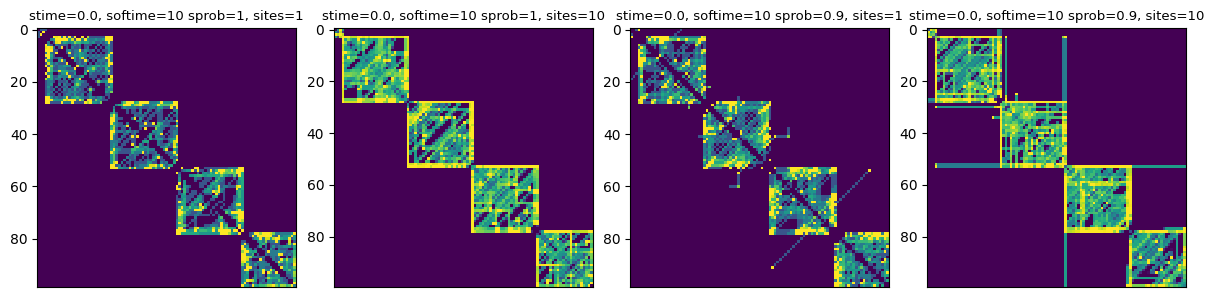

In [9]:
paramdicts = {
    'lifetime':50,
    'separation':10,
    'facestall':1,
    'backstall':0.0,
    'stalltime':1000,
    'stalloftime':0.1,
    'stalldist':10,
    'steps':200,
    'velocity_multiplier':1,
    'sites_per_monomer':10,
    'monomer_per_replica':100,
    'replication_number':10
}
facestalls=[1, 0.9]
stalltimes = [0.0]
stalloftimes = [10]
sites_per_monomers = [1, 10]
numy, numx = 10, 5
subplot_width = 3
c = 0
plt.figure(figsize=(subplot_width*numx,subplot_width*numy))
for facestall in facestalls:
    paramdicts['facestall'] = facestall
    for stalltime in stalltimes:
        paramdicts['stalltime']=stalltime
        for stalloftime in stalloftimes:
            paramdicts['stalloftime']=stalloftime
            for sites_per_monomer in sites_per_monomers:
                paramdicts['sites_per_monomer']=sites_per_monomer
                file_name = paramdict_to_filename(paramdicts)
                folder_name = '/folder_for_samples/'+'folder_' + file_name.split('file_')[1]
                folder = os.getcwd() + folder_name
                print(folder)
                if os.path.exists(folder):
                    print("already exist")
                    with  h5py.File(folder+"/LEFPositions.h5", mode='r') as myfile:
                        lef_array = np.array(myfile['positions'])
                    Trajn = 100 # trajectory length in monomer 
                    trajectoryLength = Trajn * paramdicts['sites_per_monomer'] #trajectory length in lattice land
                    Lattice_sites = paramdicts['monomer_per_replica']*paramdicts['sites_per_monomer']
                    LEFNum = 100
                    maps = map_from_lefs(lef_array, trajectoryLength, LEFNum, Lattice_sites)
                    
                    c += 1
                    plt.subplot(numy, numx, c)
                    
                    if sites_per_monomer==1:
                        plt.matshow(np.log10(maps+1),vmax=1.15/(np.sqrt(paramdicts['sites_per_monomer'])), fignum = False) 
                    else:
                        maps_coarse = cooltools.lib.numutils.zoom_array(maps, (100,100), same_sum=True)                                                  
                        plt.matshow(np.log10(maps_coarse+1),vmax=5.915/(np.sqrt(paramdicts['sites_per_monomer'])), fignum = False) 
                    
                    plt.title('stime=%s, softime=%s sprob=%s, sites=%s'%(paramdicts['stalltime'],
                                                                      paramdicts['stalloftime'],
                                                                      paramdicts['facestall'],
                                                                      paramdicts['sites_per_monomer']),fontsize=9.51)
                    plt.xticks([])
                    plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()                       
                


In [9]:
########## parameters #############
paramdict = {
    'lifetime':1000,
    'separation': 1000,
    'facestall':1,
    'backstall':1,
    'stalltime':3,
    'stalloftime':0.3,
    'stalldist':10,
    'steps':200,
    'velocity_multiplier':1,
    'sites_per_monomer':10,
    'monomer_per_replica':1500,
    'replication_number':1
}

N1 = paramdict['monomer_per_replica']   # number of monomers
M = paramdict['replication_number'] # number of replicas of the simulation
N = N1 * M  # total number of monomers
Sites_per_monomer = paramdict['sites_per_monomer']
Lattice_sites = N1 * Sites_per_monomer

RightstallList_m = [i for i in range(0, N1, N1//15)]
LeftstallList_m = [i for i in range(N1//30, N1, N1//15)]
#RightstallList_m = [15, 50,115, 175,519,670,830,1100,1180,1270,1350,1430]
#LeftstallList_m = [40,70,135,275,510,650,730,870,1185,1240,1330,1390]
RightstallList = [RightstallList_m[i]*paramdict['sites_per_monomer'] for i in range(len(RightstallList_m))]
LeftstallList = [LeftstallList_m[i] * paramdict['sites_per_monomer'] for i in range(len(LeftstallList_m))]
LEFTran, LEFNum = make_translocator(paramdict, RightstallList, LeftstallList)
#print(np.nonzero(make_stall_array(paramdict,RightstallList,LeftstallList)[1]))
#stallList=[15, 50,115, 175,519,670,830,1100,1180,1270,1350,1430]
#stallList_c=[40,70,135,275,510,650,730,870,1185,1240,1330,1390]


############# making folder for simulation ###############
file_name = paramdict_to_filename(paramdict)
folder_name = '/folder_for_samples/sims/'+'folder_2_' + file_name.split('file_')[1]
folder = os.getcwd() + folder_name

if os.path.exists(folder):
    print("already exist")
else:
    os.mkdir(folder)


########### simulation parameters ###########
Trajn = 1000 # trajectory length in monomer 
trajectoryLength = Trajn * Sites_per_monomer #trajectory length in lattice land
num_dummy_steps = 0 * Sites_per_monomer #dummy steps in lattice land
blocksteps = 50 
bins = np.linspace(0, trajectoryLength, blocksteps, dtype=int)
 
    
#########   Making LEFs arrays during trajectory length #######      
with h5py.File(folder+"/LEFPositions.h5", mode='w') as myfile:
    dset = myfile.create_dataset("positions", 
                                 shape=(trajectoryLength, LEFNum, 2), #edited
                                 dtype=np.int32, 
                                 compression="gzip")
    
    LEFTran.steps(num_dummy_steps)
    
    for st, end in zip(bins[:-1], bins[1:]):
        cur = []
        for i in range(st, end):
            LEFTran.steps(1)
            LEFs = LEFTran.getLEFs()
            #print(LEFs)
            cur.append(np.array(LEFs).T)
        cur = np.array(cur)
        dset[st:end] = cur
    myfile.attrs["N"] = N #* Sites_per_monomer
    myfile.attrs["LEFNum"] = LEFNum
print(LEFNum)

already exist


/var/folders/d5/_cxl1rhs4hjgk42126ntpj9r0000gn/T/ipykernel_65707/439390703.py:15: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  LEFTran = LEFTranslocatorDirectional(


1


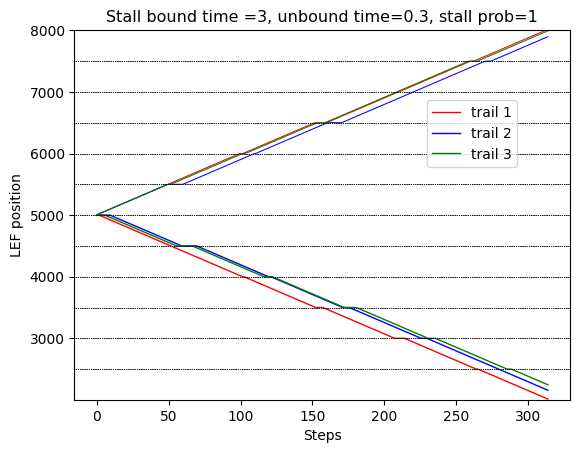

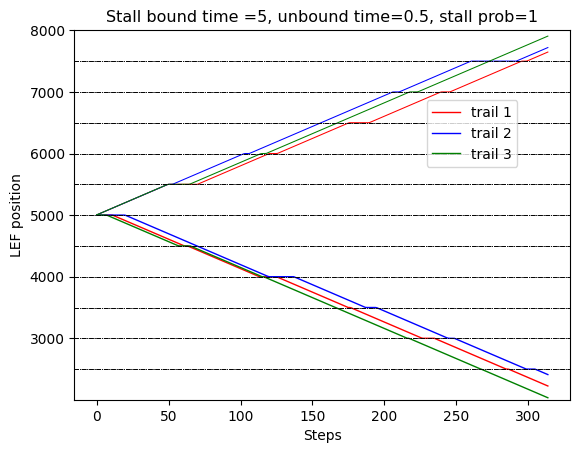

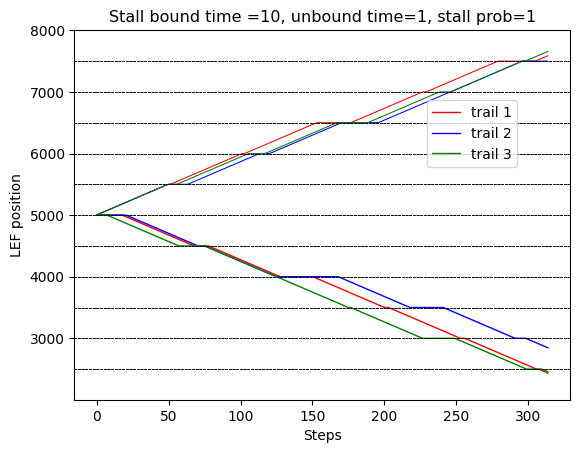

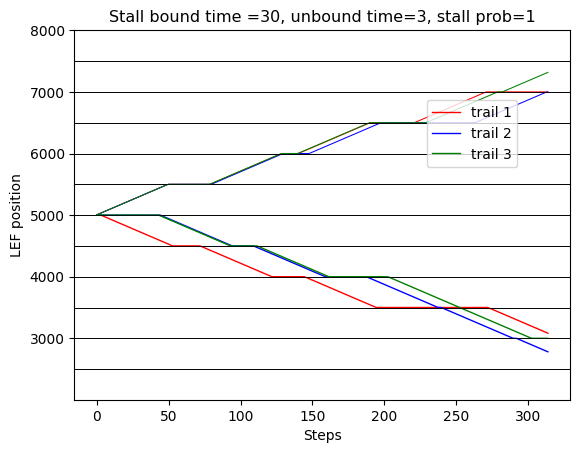

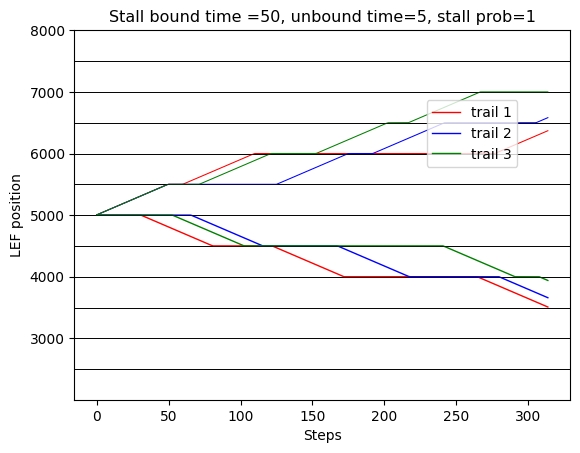

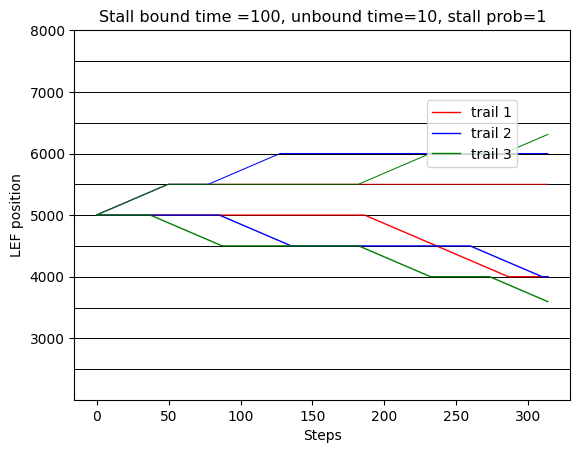

In [31]:
paramdicts = {
    'lifetime':1000,
    'separation': 1000,
    'facestall':1,
    'backstall':1,
    'stalltime':10,
    'stalloftime':1,
    'stalldist':10,
    'steps':200,
    'velocity_multiplier':1,
    'sites_per_monomer':10,
    'monomer_per_replica':1500,
    'replication_number':1
}
facestalls=[1]
stalltimes = [ 3,5,10,30,50,100]
stalloftimes = [0.3,0.5,1,3,5,10]
sites_per_monomers = [1, 10]
sites_per_monomer =paramdicts['sites_per_monomer']
c =0
m = paramdicts ['replication_number']
colors=['green','blue','red','brown','black','brown']
linelist=[':','-.','--','-','-','-']
RightstallList = [i for i in range(0, m*N1*sites_per_monomer, (N1//15)*sites_per_monomer)]
LeftstallList = [i for i in range((N1//30)*sites_per_monomer,m*N1*sites_per_monomer,(N1//15)*sites_per_monomer)]
colors=['red','blue','green']
for facestall in facestalls:
    paramdicts['facestall'] = facestall
    for stalltime in stalltimes:
        paramdicts['stalltime'] = stalltime
        for stalloftime in stalloftimes:
            paramdicts['stalloftime'] = stalloftime
            for sites_per_monomer in sites_per_monomers:
                paramdicts['sites_per_monomer'] = sites_per_monomer
                for l in range(3):
                    file_name = paramdict_to_filename(paramdicts)
                    folder_name = '/folder_for_samples/sims/'+'folder_%s_'%(l+1) + file_name.split('file_')[1]
                    folder = os.getcwd() + folder_name
                    if os.path.exists(folder):
                        #print("already exist")
                        with  h5py.File(folder + "/LEFPositions.h5", mode='r') as myfile:
                            lef_array = np.array(myfile['positions'])
                        #print(lef_array)
                        Trajn = 300 # trajectory length in monomer 
                        trajectoryLength = Trajn * paramdicts['sites_per_monomer'] #trajectory length in lattice land
                        Lattice_sites = paramdicts['monomer_per_replica'] * paramdicts['sites_per_monomer']
                        LEFNum = 1

                        c += 1
                        l_sites = lef_array[::sites_per_monomer,0,0]
                        #print(l_sites)
                        r_sites = lef_array[::sites_per_monomer,0,1]
                        if sites_per_monomer==1:
                            color='blue'
                            #print(lef_array[:,3])
                        else:
                            color='red'
                        steps = 315
                        steps_to_show = 5
                        #print(l_sites)
                        #print(r_sites)
                        plt.plot(l_sites[:steps] , color=colors[l],
                                 label='trail %s'%(l+1),linewidth=1)
                        plt.plot(r_sites[:steps] , color=colors[l], linewidth=0.75)
                        stalloftime = stalloftime
                        plt.title('Stall bound time =%s, unbound time=%s, stall prob=%s'%(stalltime, stalloftime,facestall),fontsize=11.5)
                for k in range(len(RightstallList)):
                    #print(linelist[stalltimes.index(stalltime)])
                    plt.axhline(y=RightstallList[k],color='black',linestyle = linelist[stalltimes.index(stalltime)],linewidth=0.5,alpha=0.35)
                    plt.axhline(y=LeftstallList[k], color='k',linestyle = linelist[stalltimes.index(stalltime)],linewidth=0.5,alpha=0.35)
                plt.ylabel('LEF position')
                plt.xlabel('Steps')
                plt.legend(loc=(0.71,0.63),fontsize=10)
                
        plt.ylim(l_sites[0]-3000,l_sites[0]+3000)
        plt.show()                       
                


In [ ]:
########## parameters #############
paramdict = {
    'lifetime':1000,
    'separation': 1000,
    'facestall':1,
    'backstall':1,
    'stalltime':50,
    'stalloftime':5,
    'stalldist':10,
    'steps':200,
    'velocity_multiplier':1,
    'sites_per_monomer':10,
    'monomer_per_replica':1500,
    'replication_number':1
}

N1 = paramdict['monomer_per_replica']   # number of monomers
M = paramdict['replication_number'] # number of replicas of the simulation
N = N1 * M  # total number of monomers
Sites_per_monomer = paramdict['sites_per_monomer']
Lattice_sites = N1 * Sites_per_monomer

RightstallList_m = [i for i in range(0, N1, N1//15)]
LeftstallList_m = [i for i in range(N1//30, N1, N1//15)]
#RightstallList_m = [15, 50,115, 175,519,670,830,1100,1180,1270,1350,1430]
#LeftstallList_m = [40,70,135,275,510,650,730,870,1185,1240,1330,1390]
RightstallList = [RightstallList_m[i]*paramdict['sites_per_monomer'] for i in range(len(RightstallList_m))]
LeftstallList = [LeftstallList_m[i] * paramdict['sites_per_monomer'] for i in range(len(LeftstallList_m))]
LEFTran, LEFNum = make_translocator(paramdict, RightstallList, LeftstallList)
#print(np.nonzero(make_stall_array(paramdict,RightstallList,LeftstallList)[1]))
#stallList=[15, 50,115, 175,519,670,830,1100,1180,1270,1350,1430]
#stallList_c=[40,70,135,275,510,650,730,870,1185,1240,1330,1390]


############# making folder for simulation ###############
file_name = paramdict_to_filename(paramdict)
folder_name = '/folder_for_samples/sims/'+'folder_3_' + file_name.split('file_')[1]
folder = os.getcwd() + folder_name

if os.path.exists(folder):
    print("already exist")
else:
    os.mkdir(folder)


########### simulation parameters ###########
Trajn = 1000 # trajectory length in monomer 
trajectoryLength = Trajn * Sites_per_monomer #trajectory length in lattice land
num_dummy_steps = 0 * Sites_per_monomer #dummy steps in lattice land
blocksteps = 50 
bins = np.linspace(0, trajectoryLength, blocksteps, dtype=int)
 
    
#########   Making LEFs arrays during trajectory length #######      
with h5py.File(folder+"/LEFPositions.h5", mode='w') as myfile:
    dset = myfile.create_dataset("positions", 
                                 shape=(trajectoryLength, LEFNum, 2), #edited
                                 dtype=np.int32, 
                                 compression="gzip")
    
    LEFTran.steps(num_dummy_steps)
    
    for st, end in zip(bins[:-1], bins[1:]):
        cur = []
        for i in range(st, end):
            LEFTran.steps(1)
            LEFs = LEFTran.getLEFs()
            #print(LEFs)
            cur.append(np.array(LEFs).T)
        cur = np.array(cur)
        dset[st:end] = cur
    myfile.attrs["N"] = N #* Sites_per_monomer
    myfile.attrs["LEFNum"] = LEFNum
print(LEFNum)

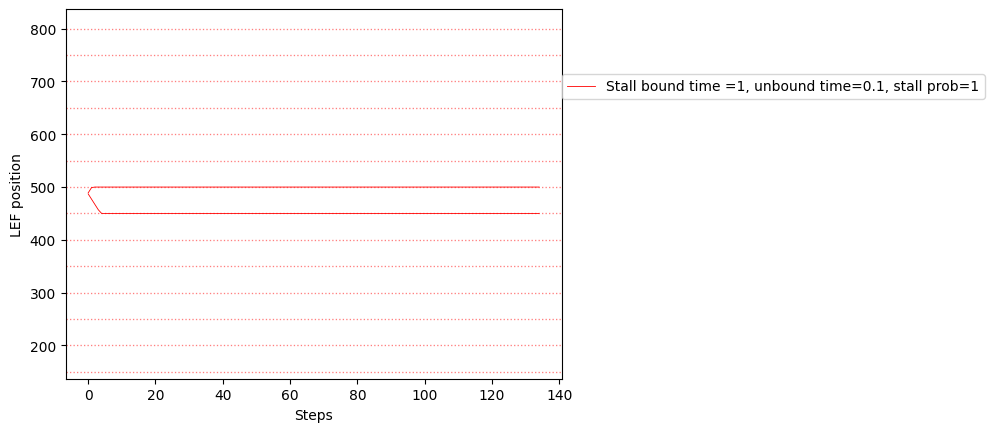

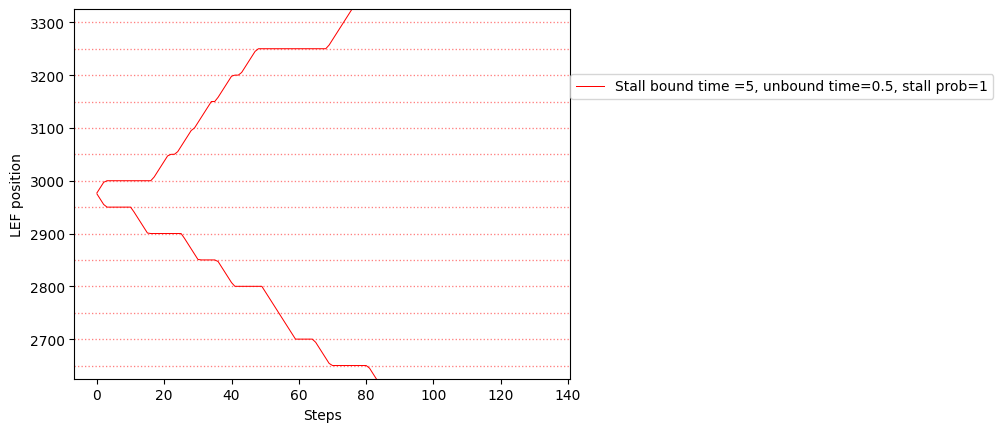

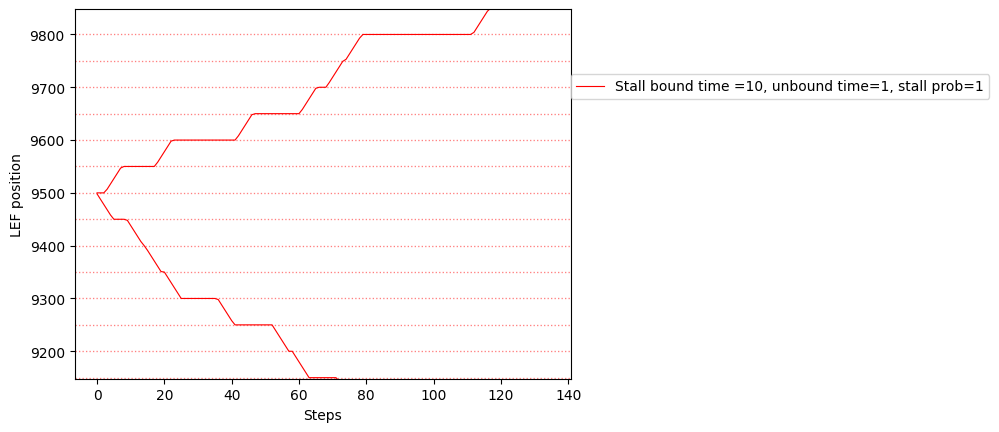

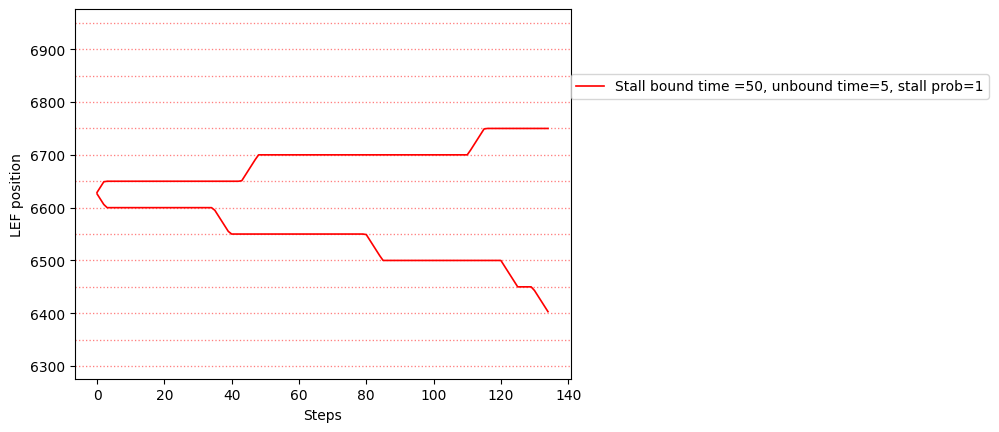

In [97]:
paramdicts = {
    'lifetime':1000,
    'separation': 750,
    'facestall':1,
    'backstall':1,
    'stalltime':10,
    'stalloftime':1,
    'stalldist':10,
    'steps':200,
    'velocity_multiplier':1,
    'sites_per_monomer':10,
    'monomer_per_replica':150,
    'replication_number':10
}
facestalls=[1]
stalltimes = [1, 5, 10, 50]
stalloftimes = [0.1, 0.5, 1, 5]
sites_per_monomers = [1, 10]
c =0
m = paramdicts ['replication_number']
colors=['green','blue','red','brown']
RightstallList = [i for i in range(0, m*N1*sites_per_monomer, (N1//15)*sites_per_monomer)]
LeftstallList = [i for i in range((N1//30)*sites_per_monomer,m*N1*sites_per_monomer,(N1//15)*sites_per_monomer)]

for facestall in facestalls:
    paramdicts['facestall'] = facestall
    for stalltime in stalltimes:
        paramdicts['stalltime'] = stalltime
        for stalloftime in stalloftimes:
            paramdicts['stalloftime'] = stalloftime
            for sites_per_monomer in sites_per_monomers:
                paramdicts['sites_per_monomer'] = sites_per_monomer
                file_name = paramdict_to_filename(paramdicts)
                folder_name = '/folder_for_samples/sims/'+'folder_' + file_name.split('file_')[1]
                folder = os.getcwd() + folder_name
                if os.path.exists(folder):
                    #print("already exist")
                    with  h5py.File(folder + "/LEFPositions.h5", mode='r') as myfile:
                        lef_array = np.array(myfile['positions'])
                    Trajn = 300 # trajectory length in monomer 
                    trajectoryLength = Trajn * paramdicts['sites_per_monomer'] #trajectory length in lattice land
                    Lattice_sites = paramdicts['monomer_per_replica'] * paramdicts['sites_per_monomer']
                    LEFNum = 1
                    
                    c += 1
                    l_sites = lef_array[::sites_per_monomer,0,0]
                    r_sites = lef_array[::sites_per_monomer,0,1]
                    if sites_per_monomer==1:
                        color='blue'
                        print(lef_array[:,3])
                    else:
                        color='red'
                    steps = 135
                    steps_to_show = 5
                    #print(l_sites)
                    #print(r_sites)
                    plt.plot(l_sites[:steps] , color=color,
                             label='Stall bound time =%s, unbound time=%s, stall prob=%s'%(stalltime, stalloftime,facestall),linewidth=np.sqrt(stalltime)/10+0.5)
                    plt.plot(r_sites[:steps] , color=color,linewidth=np.sqrt(stalltime)/10 + 0.5)
                    #plt.scatter(np.arange(0,steps)[::steps_to_show],(l_sites[:steps:steps_to_show] - l_sites[0])/sites_per_monomer, color=color,s=3+stalltime/5)
                    #plt.scatter(np.arange(0,steps)[::steps_to_show],(r_sites[:steps:steps_to_show] - l_sites[0])/sites_per_monomer, color=color,s=3+stalltime/5)
                    for k in range(len(RightstallList)):
                        #print(RightstallList[k]-l_sites[0]/sites_per_monomer)
                        plt.axhline(y=RightstallList[k],color=color,linestyle = ':',linewidth=0.95,alpha=0.5)
                        plt.axhline(y=LeftstallList[k],color=color, linestyle = ':',linewidth=0.95,alpha=0.5)
                    plt.ylabel('LEF position')
                    plt.xlabel('Steps')
                    plt.legend(loc=(1,0.757),fontsize=10)
        #plt.title('Stall bound time =%s, unbound time=%s, stall prob=%s'%(stalltime, stalloftime,facestall))
        plt.ylim(l_sites[0]-350,l_sites[0]+350)
        plt.show()                       
                


In [27]:
m = paramdicts ['replication_number']
RightstallList = [i for i in range(0, m*N1, (N1//15))]
LeftstallList = [i for i in range(N1//30,m*N1,(N1//15))]
print(RightstallList)

[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400, 5500, 5600, 5700, 5800, 5900, 6000, 6100, 6200, 6300, 6400, 6500, 6600, 6700, 6800, 6900, 7000, 7100, 7200, 7300, 7400, 7500, 7600, 7700, 7800, 7900, 8000, 8100, 8200, 8300, 8400, 8500, 8600, 8700, 8800, 8900, 9000, 9100, 9200, 9300, 9400, 9500, 9600, 9700, 9800, 9900, 10000, 10100, 10200, 10300, 10400, 10500, 10600, 10700, 10800, 10900, 11000, 11100, 11200, 11300, 11400, 11500, 11600, 11700, 11800, 11900, 12000, 12100, 12200, 12300, 12400, 12500, 12600, 12700, 12800, 12900, 13000, 13100, 13200, 13300, 13400, 13500, 13600, 13700, 13800, 13900, 14000, 14100, 14200, 14300, 14400, 14500, 14600, 14700, 14800, 14900]


In [18]:
lists=make_stall_array(paramdict, RightstallList, LeftstallList)

print(np.nonzero(lists[0]),np.nonzero(lists[1]))
lst= list(np.sort(RightstallList + LeftstallList))
print(lst)

(array([  150,   400,   500,   700,  1150,  1350,  1750,  2750,  5100,
        5190,  6500,  6700,  7300,  8300,  8700, 11000, 11800, 11850,
       12400, 12700, 13300, 13500, 13900, 14300]),) (array([  150,   400,   500,   700,  1150,  1350,  1750,  2750,  5100,
        5190,  6500,  6700,  7300,  8300,  8700, 11000, 11800, 11850,
       12400, 12700, 13300, 13500, 13900, 14300]),)
[150, 400, 500, 700, 1150, 1350, 1750, 2750, 5100, 5190, 6500, 6700, 7300, 8300, 8700, 11000, 11800, 11850, 12400, 12700, 13300, 13500, 13900, 14300]


In [ ]:
RightstallList_m = [15, 50,115, 175,519,670,830,1100,1180,1270,1350,1430]
LeftstallList_m = [40,70,135,275,510,650,730,870,1185,1240,1330,1390]
RightstallList = [RightstallList_m[i]*paramdict['sites_per_monomer'] for i in range(len(RightstallList_m))]
LeftstallList = [LeftstallList_m[i] * paramdict['sites_per_monomer'] for i in range(len(LeftstallList_m))]
print(RightstallList)

In [ ]:
print(folder)

### Virtual Chip-Seq

/home1/rahmanin/start/polychrom/simulations_with_ratio/lattice/folder_for_samples/sims/folder_1_lif_50_sep_100_fac_0.9_bac_0.0_sta_0.0_sta_10_sta_10_ste_200_vel_1_sit_1_mon_1500_rep_10
1
/home1/rahmanin/start/polychrom/simulations_with_ratio/lattice/folder_for_samples/sims/folder_1_lif_50_sep_100_fac_0.9_bac_0.0_sta_0.0_sta_10_sta_10_ste_200_vel_1_sit_10_mon_1500_rep_10
1
folder exist
0.2765973063973064
/home1/rahmanin/start/polychrom/simulations_with_ratio/lattice/folder_for_samples/sims/folder_2_lif_50_sep_100_fac_0.9_bac_0.0_sta_0.0_sta_10_sta_10_ste_200_vel_1_sit_1_mon_1500_rep_10
2
/home1/rahmanin/start/polychrom/simulations_with_ratio/lattice/folder_for_samples/sims/folder_2_lif_50_sep_100_fac_0.9_bac_0.0_sta_0.0_sta_10_sta_10_ste_200_vel_1_sit_10_mon_1500_rep_10
2
folder exist
0.2737084175084175
/home1/rahmanin/start/polychrom/simulations_with_ratio/lattice/folder_for_samples/sims/folder_3_lif_50_sep_100_fac_0.9_bac_0.0_sta_0.0_sta_10_sta_10_ste_200_vel_1_sit_1_mon_1500_rep_10
3

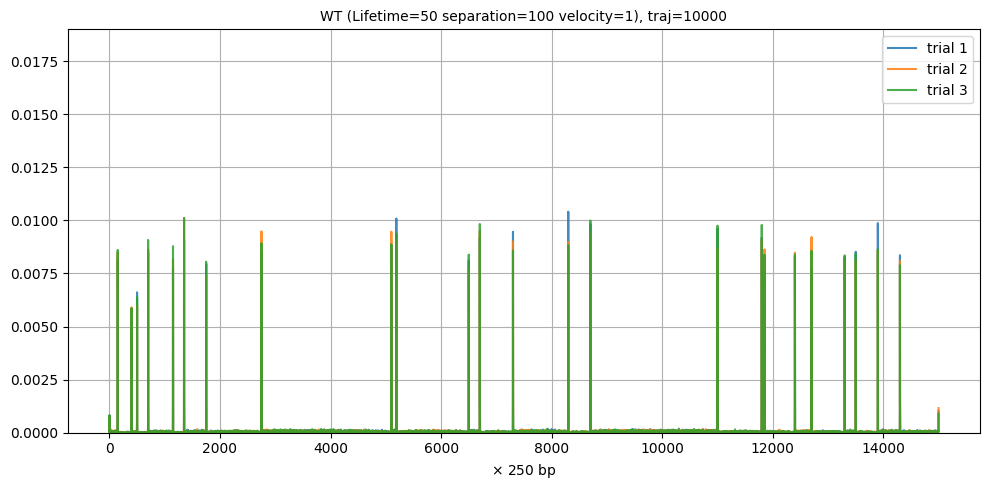

In [80]:
paramdicts = {
    'lifetime':50,
    'separation':100,
    'facestall':0.9,
    'backstall':0.0,
    'stalltime':0.0,
    'stalloftime':10,
    'stalldist':10,
    'steps':200,
    'velocity_multiplier':1,
    'sites_per_monomer':10,
    'monomer_per_replica':1500,
    'replication_number':10
}
N1 = paramdict['monomer_per_replica']

mapN= N1
numx,numy = 1,1
min_time = 1000
c=0
hist_dict = {}


facestalls=[0.9]
stalltimes = [0.0]
stalloftimes = [10]
sites_per_monomers = [1, 10]


    
###################
def peak_positions(lst, window_sizes=[1]):
    peak_monomers = np.array([])
    for i in window_sizes:
        inds_to_add=[lst[j]+i for j in range(len(lst))]
        peak_monomers = np.hstack((peak_monomers,inds_to_add))
    return peak_monomers.astype(int)

def FRiP(num_monomers, lef_positions, num_replica,peak_positions ):
    
    a,b = np.histogram(  lef_positions  , np.arange(num_monomers) )
    return np.sum(a[peak_positions] )/(len(lef_positions)/num_replica)
###################


plt.figure(figsize=(10,5))
for s in range(3):
    for facestall in facestalls:
        paramdicts['facestall'] = facestall
        for stalltime in stalltimes:
            paramdicts['stalltime']=stalltime
            for stalloftime in stalloftimes:
                paramdicts['stalloftime']=stalloftime
                for sites_per_monomer in sites_per_monomers:
                    paramdicts['sites_per_monomer']=sites_per_monomer
                    file_name = paramdict_to_filename(paramdicts)
                    folder_name = '/folder_for_samples/sims/'+'folder_%s_'%(s+1) + file_name.split('file_')[1]
                    folder = os.getcwd() + folder_name
                    print(folder)
                    print(s+1)
                    if os.path.exists(folder):
                        c+=1
                        #plt.subplot(1,1, c)
                        print("folder exist")
                        with  h5py.File(folder+"/LEFPositions.h5", mode='r') as myfile:
                            lefs = np.array(myfile['positions'])
                            #print(lefs)
                            lef_lefts = lefs[min_time:,:,0].flatten()
                            lef_rights = lefs[min_time:,:,1].flatten()
                            lef_positions = np.hstack((lef_lefts,lef_rights))
                            mapN = N1 * sites_per_monomer
                            a,b = np.histogram(  np.mod( np.hstack((lef_lefts,lef_rights)) , mapN ), np.arange(0,mapN,1))

                            window_size=0



                            RightstallList_m = [15, 50,115, 175,519,670,830,1100,1180,1270,1350,1430]
                            LeftstallList_m = [40,70,135,275,510,650,730,870,1185,1240,1330,1390]
                            RightstallList = [RightstallList_m[i]*paramdicts['sites_per_monomer'] for i in range(len(RightstallList_m))]
                            LeftstallList = [LeftstallList_m[i] * paramdicts['sites_per_monomer'] for i in range(len(LeftstallList_m))]
                            lst= list(np.sort(RightstallList + LeftstallList))


                            window_size=int(paramdicts['sites_per_monomer']/2)
                            #window_size=0
                            peak_monomers = peak_positions(lst,window_sizes=np.arange(-window_size,window_size+1) )



                            Frip_sco=FRiP(mapN, lef_positions, 10,peak_monomers)
                            print(Frip_sco)
                            #print(len(lef_positions)/np.sum(a))
                            plt.plot(a/np.sum(a),label='trial %s'%(s+1),alpha=0.85)
plt.ylim([0,.019])
                            #plt.xlim(0,300)
plt.grid(True)
                            #hist_dict[name] = a/np.sum(a)
plt.title('WT (Lifetime=%s separation=%s velocity=%s), traj=10000'%(paramdicts['lifetime'],paramdicts['separation'],paramdicts['velocity_multiplier']),fontsize=10)
                        #plt.title('Lifetime=%s separation=%s velocity=%s sites_per_monomer=%s Frip=%0.3f window size=%s'%(paramdicts['lifetime']
                        #                                                                            ,paramdicts['separation']
                        #                                                                            ,paramdicts['velocity_multiplier']
                        #                                                                            ,paramdicts['sites_per_monomer']
                        #                                                                            ,Frip_sco, window_size+1),fontsize=10)
plt.legend()
plt.xlabel(r'$\times$ 250 bp')
plt.tight_layout()    
plt.show()                    

/home1/rahmanin/start/polychrom/simulations_with_ratio/lattice/folder_for_samples/sims/folder_lif_50_sep_100_fac_0.9_bac_0.0_sta_0.0_sta_10_sta_10_ste_200_vel_1_sit_1_mon_1500_rep_10
folder exist
0.2110404761904762
/home1/rahmanin/start/polychrom/simulations_with_ratio/lattice/folder_for_samples/sims/folder_lif_50_sep_100_fac_0.9_bac_0.0_sta_0.0_sta_10_sta_10_ste_200_vel_1_sit_10_mon_1500_rep_10
folder exist
0.2011192393736018


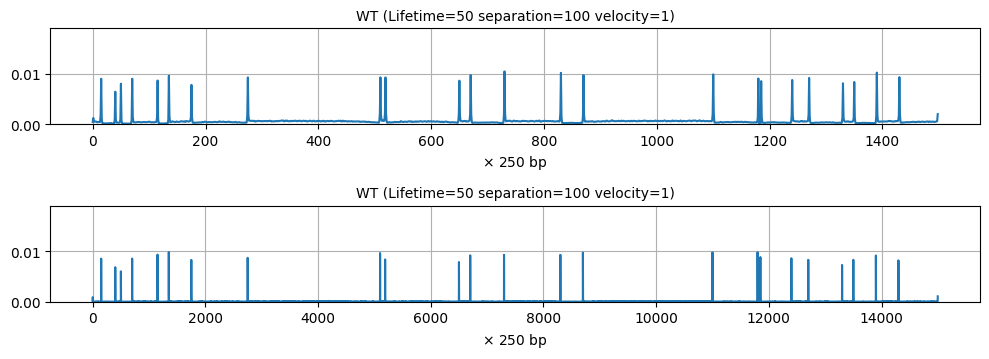

In [24]:
paramdicts = {
    'lifetime':50,
    'separation':100,
    'facestall':0.9,
    'backstall':0.0,
    'stalltime':0.0,
    'stalloftime':10,
    'stalldist':10,
    'steps':200,
    'velocity_multiplier':1,
    'sites_per_monomer':10,
    'monomer_per_replica':1500,
    'replication_number':10
}
N1 = paramdict['monomer_per_replica']

mapN= N1
numx,numy = 1,1
min_time = 1000
c=0
hist_dict = {}


facestalls=[0.9]
stalltimes = [0.0]
stalloftimes = [10]
sites_per_monomers = [1, 10]


    
###################
def peak_positions(lst, window_sizes=[1]):
    peak_monomers = np.array([])
    for i in window_sizes:
        inds_to_add=[lst[j]+i for j in range(len(lst))]
        peak_monomers = np.hstack((peak_monomers,inds_to_add))
    return peak_monomers.astype(int)

def FRiP(num_monomers, lef_positions, num_replica,peak_positions ):
    
    a,b = np.histogram(  lef_positions  , np.arange(num_monomers) )
    return np.sum(a[peak_positions] )/(len(lef_positions)/num_replica)
###################


plt.figure(figsize=(10,5))
for facestall in facestalls:
    paramdicts['facestall'] = facestall
    for stalltime in stalltimes:
        paramdicts['stalltime']=stalltime
        for stalloftime in stalloftimes:
            paramdicts['stalloftime']=stalloftime
            for sites_per_monomer in sites_per_monomers:
                paramdicts['sites_per_monomer']=sites_per_monomer
                file_name = paramdict_to_filename(paramdicts)
                folder_name = '/folder_for_samples/sims/'+'folder_' + file_name.split('file_')[1]
                folder = os.getcwd() + folder_name
                print(folder)
                
                if os.path.exists(folder):
                    c+=1
                    plt.subplot(3,1, c)
                    print("folder exist")
                    with  h5py.File(folder+"/LEFPositions.h5", mode='r') as myfile:
                        lefs = np.array(myfile['positions'])
                        #print(lefs)
                        lef_lefts = lefs[min_time:,:,0].flatten()
                        lef_rights = lefs[min_time:,:,1].flatten()
                        lef_positions = np.hstack((lef_lefts,lef_rights))
                        mapN = N1 * sites_per_monomer
                        a,b = np.histogram(  np.mod( np.hstack((lef_lefts,lef_rights)) , mapN ), np.arange(0,mapN,1))
                        
                        window_size=0
                        
                        
                        
                        RightstallList_m = [15, 50,115, 175,519,670,830,1100,1180,1270,1350,1430]
                        LeftstallList_m = [40,70,135,275,510,650,730,870,1185,1240,1330,1390]
                        RightstallList = [RightstallList_m[i]*paramdicts['sites_per_monomer'] for i in range(len(RightstallList_m))]
                        LeftstallList = [LeftstallList_m[i] * paramdicts['sites_per_monomer'] for i in range(len(LeftstallList_m))]
                        lst= list(np.sort(RightstallList + LeftstallList))
                        
                        
                        
                        peak_monomers = peak_positions(lst,window_sizes=np.arange(-window_size,window_size+1) )
                        
                        
                        
                        Frip_sco=FRiP(mapN, lef_positions, 10,peak_monomers)
                        #print(len(lef_positions)/np.sum(a))
                        print(Frip_sco)
                        plt.plot(a/np.sum(a))
                        plt.ylim([0,.019])
                        #plt.xlim(0,300)
                        plt.grid(True)
                        #hist_dict[name] = a/np.sum(a)
                        plt.title(r'WT (Lifetime=%s separation=%s velocity=%s)'%(paramdicts['lifetime']
                                                                                                ,paramdicts['separation']
                                                                                                ,paramdicts['velocity_multiplier']
                                                                                                ),fontsize=10)
                        plt.xlabel(r'$\times$ 250 bp')
                        
                    plt.tight_layout()    
    

/home1/rahmanin/start/polychrom/simulations_with_ratio/lattice/folder_for_samples/sims/folder_lif_50_sep_100_fac_0.9_bac_0.9_sta_0.0_sta_10_sta_10_ste_200_vel_1_sit_1_mon_1500_rep_10
/home1/rahmanin/start/polychrom/simulations_with_ratio/lattice/folder_for_samples/sims/folder_lif_50_sep_100_fac_0.9_bac_0.9_sta_0.0_sta_10_sta_10_ste_200_vel_1_sit_10_mon_1500_rep_10
folder exist
0.3094532438478747


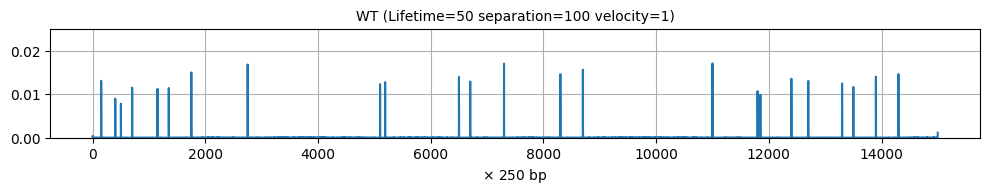

In [28]:
paramdicts = {
    'lifetime':50,
    'separation':100,
    'facestall':0.9,
    'backstall':0.9,
    'stalltime':0.0,
    'stalloftime':10,
    'stalldist':10,
    'steps':200,
    'velocity_multiplier':1,
    'sites_per_monomer':10,
    'monomer_per_replica':1500,
    'replication_number':10
}
N1 = paramdict['monomer_per_replica']

mapN= N1
numx,numy = 1,1
min_time = 1000
c=0
hist_dict = {}


facestalls=[0.9]
stalltimes = [0.0]
stalloftimes = [10]
sites_per_monomers = [1, 10]


    
###################
def peak_positions(lst, window_sizes=[1]):
    peak_monomers = np.array([])
    for i in window_sizes:
        inds_to_add=[lst[j]+i for j in range(len(lst))]
        peak_monomers = np.hstack((peak_monomers,inds_to_add))
    return peak_monomers.astype(int)

def FRiP(num_monomers, lef_positions, num_replica,peak_positions ):
    
    a,b = np.histogram(  lef_positions  , np.arange(num_monomers) )
    return np.sum(a[peak_positions] )/(len(lef_positions)/num_replica)
###################


plt.figure(figsize=(10,5))
for facestall in facestalls:
    paramdicts['facestall'] = facestall
    for stalltime in stalltimes:
        paramdicts['stalltime']=stalltime
        for stalloftime in stalloftimes:
            paramdicts['stalloftime']=stalloftime
            for sites_per_monomer in sites_per_monomers:
                paramdicts['sites_per_monomer']=sites_per_monomer
                file_name = paramdict_to_filename(paramdicts)
                folder_name = '/folder_for_samples/sims/'+'folder_' + file_name.split('file_')[1]
                folder = os.getcwd() + folder_name
                print(folder)
                
                if os.path.exists(folder):
                    c+=1
                    plt.subplot(3,1, c)
                    print("folder exist")
                    with  h5py.File(folder+"/LEFPositions.h5", mode='r') as myfile:
                        lefs = np.array(myfile['positions'])
                        #print(lefs)
                        lef_lefts = lefs[min_time:,:,0].flatten()
                        lef_rights = lefs[min_time:,:,1].flatten()
                        lef_positions = np.hstack((lef_lefts,lef_rights))
                        mapN = N1 * sites_per_monomer
                        a,b = np.histogram(  np.mod( np.hstack((lef_lefts,lef_rights)) , mapN ), np.arange(0,mapN,1))
                        
                        window_size=0
                        
                        
                        
                        RightstallList_m = [15, 50,115, 175,519,670,830,1100,1180,1270,1350,1430]
                        LeftstallList_m = [40,70,135,275,510,650,730,870,1185,1240,1330,1390]
                        RightstallList = [RightstallList_m[i]*paramdicts['sites_per_monomer'] for i in range(len(RightstallList_m))]
                        LeftstallList = [LeftstallList_m[i] * paramdicts['sites_per_monomer'] for i in range(len(LeftstallList_m))]
                        lst= list(np.sort(RightstallList + LeftstallList))
                        
                        
                        
                        peak_monomers = peak_positions(lst,window_sizes=np.arange(-window_size,window_size+1) )
                        
                        
                        
                        Frip_sco=FRiP(mapN, lef_positions, 10,peak_monomers)
                        #print(len(lef_positions)/np.sum(a))
                        print(Frip_sco)
                        plt.plot(a/np.sum(a))
                        plt.ylim([0,.0251])
                        #plt.xlim(0,300)
                        plt.grid(True)
                        #hist_dict[name] = a/np.sum(a)
                        plt.title(r'WT (Lifetime=%s separation=%s velocity=%s)'%(paramdicts['lifetime']
                                                                                                ,paramdicts['separation']
                                                                                                ,paramdicts['velocity_multiplier']
                                                                                                ),fontsize=10)
                        plt.xlabel(r'$\times$ 250 bp')
                        
                    plt.tight_layout()    
    

/home1/rahmanin/start/polychrom/simulations_with_ratio/lattice/folder_for_samples/sims/folder_lif_50_sep_75_fac_0.9_bac_0.9_sta_0.0_sta_10_sta_10_ste_200_vel_1_sit_1_mon_1500_rep_10
/home1/rahmanin/start/polychrom/simulations_with_ratio/lattice/folder_for_samples/sims/folder_lif_50_sep_75_fac_0.9_bac_0.9_sta_0.0_sta_10_sta_10_ste_200_vel_1_sit_10_mon_1500_rep_10
folder exist
0.28083741610738255


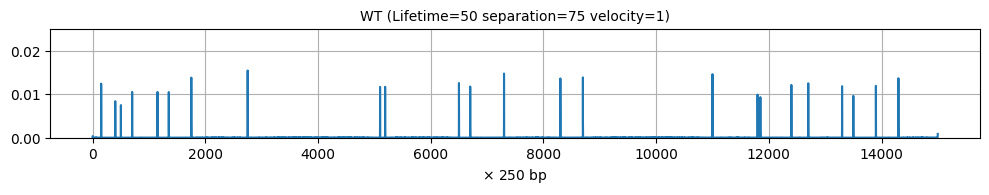

In [27]:
paramdicts = {
    'lifetime':50,
    'separation':75,
    'facestall':0.9,
    'backstall':0.9,
    'stalltime':0.0,
    'stalloftime':10,
    'stalldist':10,
    'steps':200,
    'velocity_multiplier':1,
    'sites_per_monomer':10,
    'monomer_per_replica':1500,
    'replication_number':10
}
N1 = paramdict['monomer_per_replica']

mapN= N1
numx,numy = 1,1
min_time = 1000
c=0
hist_dict = {}


facestalls=[0.9]
stalltimes = [0.0]
stalloftimes = [10]
sites_per_monomers = [1, 10]


    
###################
def peak_positions(lst, window_sizes=[1]):
    peak_monomers = np.array([])
    for i in window_sizes:
        inds_to_add=[lst[j]+i for j in range(len(lst))]
        peak_monomers = np.hstack((peak_monomers,inds_to_add))
    return peak_monomers.astype(int)

def FRiP(num_monomers, lef_positions, num_replica,peak_positions ):
    
    a,b = np.histogram(  lef_positions  , np.arange(num_monomers) )
    return np.sum(a[peak_positions] )/(len(lef_positions)/num_replica)
###################


plt.figure(figsize=(10,5))
for facestall in facestalls:
    paramdicts['facestall'] = facestall
    for stalltime in stalltimes:
        paramdicts['stalltime']=stalltime
        for stalloftime in stalloftimes:
            paramdicts['stalloftime']=stalloftime
            for sites_per_monomer in sites_per_monomers:
                paramdicts['sites_per_monomer']=sites_per_monomer
                file_name = paramdict_to_filename(paramdicts)
                folder_name = '/folder_for_samples/sims/'+'folder_' + file_name.split('file_')[1]
                folder = os.getcwd() + folder_name
                print(folder)
                
                if os.path.exists(folder):
                    c+=1
                    plt.subplot(3,1, c)
                    print("folder exist")
                    with  h5py.File(folder+"/LEFPositions.h5", mode='r') as myfile:
                        lefs = np.array(myfile['positions'])
                        #print(lefs)
                        lef_lefts = lefs[min_time:,:,0].flatten()
                        lef_rights = lefs[min_time:,:,1].flatten()
                        lef_positions = np.hstack((lef_lefts,lef_rights))
                        mapN = N1 * sites_per_monomer
                        a,b = np.histogram(  np.mod( np.hstack((lef_lefts,lef_rights)) , mapN ), np.arange(0,mapN,1))
                        
                        window_size=0
                        
                        
                        
                        RightstallList_m = [15, 50,115, 175,519,670,830,1100,1180,1270,1350,1430]
                        LeftstallList_m = [40,70,135,275,510,650,730,870,1185,1240,1330,1390]
                        RightstallList = [RightstallList_m[i]*paramdicts['sites_per_monomer'] for i in range(len(RightstallList_m))]
                        LeftstallList = [LeftstallList_m[i] * paramdicts['sites_per_monomer'] for i in range(len(LeftstallList_m))]
                        lst= list(np.sort(RightstallList + LeftstallList))
                        
                        
                        
                        peak_monomers = peak_positions(lst,window_sizes=np.arange(-window_size,window_size+1) )
                        
                        
                        
                        Frip_sco=FRiP(mapN, lef_positions, 10,peak_monomers)
                        #print(len(lef_positions)/np.sum(a))
                        print(Frip_sco)
                        plt.plot(a/np.sum(a))
                        plt.ylim([0,.0251])
                        #plt.xlim(0,300)
                        plt.grid(True)
                        #hist_dict[name] = a/np.sum(a)
                        plt.title(r'WT (Lifetime=%s separation=%s velocity=%s)'%(paramdicts['lifetime']
                                                                                                ,paramdicts['separation']
                                                                                                ,paramdicts['velocity_multiplier']
                                                                                                ),fontsize=10)
                        plt.xlabel(r'$\times$ 250 bp')
                        
                    plt.tight_layout()    
    

0.33059285714285713
0.3099675615212528


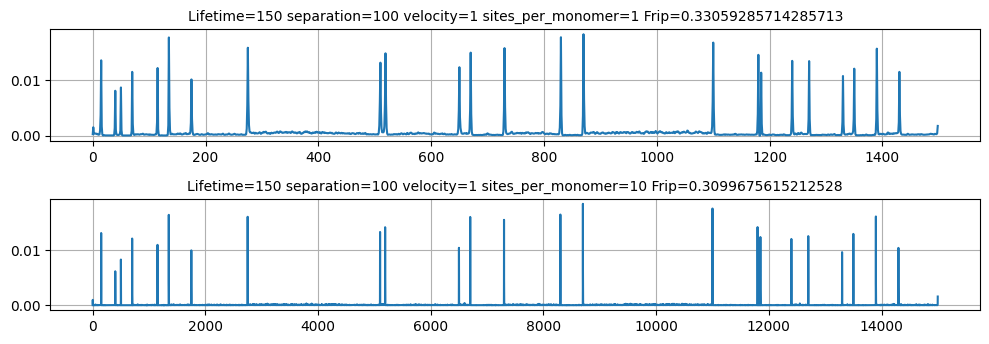

In [57]:
paramdicts = {
    'lifetime':150,
    'separation':100,
    'facestall':0.9,
    'backstall':0.0,
    'stalltime':0.0,
    'stalloftime':10,
    'stalldist':10,
    'steps':200,
    'velocity_multiplier':1,
    'sites_per_monomer':10,
    'monomer_per_replica':1500,
    'replication_number':10
}
N1 = paramdict['monomer_per_replica']

mapN= N1
numx,numy = 1,1
min_time = 1000
c=0
hist_dict = {}


facestalls=[0.9]
stalltimes = [0.0]
stalloftimes = [10]
sites_per_monomers = [1, 10]


    
###################
def peak_positions(lst, window_sizes=[1]):
    peak_monomers = np.array([])
    for i in window_sizes:
        inds_to_add=[lst[j]+i for j in range(len(lst))]
        peak_monomers = np.hstack((peak_monomers,inds_to_add))
    return peak_monomers.astype(int)

def FRiP(num_monomers, lef_positions, num_replica,peak_positions ):
    
    a,b = np.histogram(  lef_positions  , np.arange(num_monomers) )
    return np.sum(a[peak_positions] )/(len(lef_positions)/num_replica)
###################


plt.figure(figsize=(10,5))
for facestall in facestalls:
    paramdicts['facestall'] = facestall
    for stalltime in stalltimes:
        paramdicts['stalltime']=stalltime
        for stalloftime in stalloftimes:
            paramdicts['stalloftime']=stalloftime
            for sites_per_monomer in sites_per_monomers:
                paramdicts['sites_per_monomer']=sites_per_monomer
                file_name = paramdict_to_filename(paramdicts)
                folder_name = '/folder_for_samples/sims/'+'folder_' + file_name.split('file_')[1]
                folder = os.getcwd() + folder_name
                #print(folder)
                
                if os.path.exists(folder):
                    c+=1
                    plt.subplot(3,1, c)
                    #print("folder exist")
                    with  h5py.File(folder+"/LEFPositions.h5", mode='r') as myfile:
                        lefs = np.array(myfile['positions'])
                        #print(lefs)
                        lef_lefts = lefs[min_time:,:,0].flatten()
                        lef_rights = lefs[min_time:,:,1].flatten()
                        lef_positions = np.hstack((lef_lefts,lef_rights))
                        mapN = N1 * sites_per_monomer
                        a,b = np.histogram(  np.mod( np.hstack((lef_lefts,lef_rights)) , mapN ), np.arange(0,mapN,1))
                        
                        window_size=0
                        
                        
                        #window_size=int(paramdicts['sites_per_monomer']/2)
                        RightstallList_m = [15, 50,115, 175,519,670,830,1100,1180,1270,1350,1430]
                        LeftstallList_m = [40,70,135,275,510,650,730,870,1185,1240,1330,1390]
                        RightstallList = [RightstallList_m[i]*paramdicts['sites_per_monomer'] for i in range(len(RightstallList_m))]
                        LeftstallList = [LeftstallList_m[i] * paramdicts['sites_per_monomer'] for i in range(len(LeftstallList_m))]
                        lst= list(np.sort(RightstallList + LeftstallList))
                        
                        
                        
                        peak_monomers = peak_positions(lst,window_sizes=np.arange(-window_size,window_size+1) )
                        
                        
                        
                        Frip_sco=FRiP(mapN, lef_positions, 10,peak_monomers)
                        #print(len(lef_positions)/np.sum(a))
                        print(Frip_sco)
                        plt.plot(a/np.sum(a))
                        #plt.ylim([0,.019])
                        #plt.xlim(0,300)
                        plt.grid(True)
                        #hist_dict[name] = a/np.sum(a)
                        plt.title('Lifetime=%s separation=%s velocity=%s sites_per_monomer=%s Frip=%s'%(paramdicts['lifetime']
                                                                                                ,paramdicts['separation']
                                                                                                ,paramdicts['velocity_multiplier']
                                                                                                ,paramdicts['sites_per_monomer']
                                                                                                ,Frip_sco),fontsize=10)
                        
                    plt.tight_layout()    
    

/home1/rahmanin/start/polychrom/simulations_with_ratio/lattice/folder_for_samples/sims/folder_lif_150_sep_75_fac_0.9_bac_0.0_sta_0.0_sta_10_sta_10_ste_200_vel_1_sit_1_mon_1500_rep_10
folder exist
0.28059464285714286
/home1/rahmanin/start/polychrom/simulations_with_ratio/lattice/folder_for_samples/sims/folder_lif_150_sep_75_fac_0.9_bac_0.0_sta_0.0_sta_10_sta_10_ste_200_vel_1_sit_10_mon_1500_rep_10
folder exist
0.26490687919463085


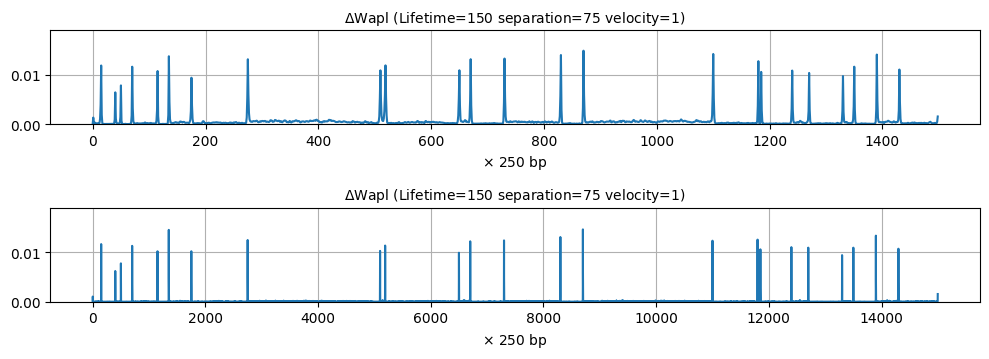

In [54]:
paramdicts = {
    'lifetime':150,
    'separation':75,
    'facestall':0.9,
    'backstall':0.0,
    'stalltime':0.0,
    'stalloftime':10,
    'stalldist':10,
    'steps':200,
    'velocity_multiplier':1,
    'sites_per_monomer':10,
    'monomer_per_replica':1500,
    'replication_number':10
}
N1 = paramdict['monomer_per_replica']

mapN= N1
numx,numy = 1,1
min_time = 1000
c=0
hist_dict = {}


facestalls=[0.9]
stalltimes = [0.0]
stalloftimes = [10]
sites_per_monomers = [1, 10]


    
###################
def peak_positions(lst, window_sizes=[1]):
    peak_monomers = np.array([])
    for i in window_sizes:
        inds_to_add=[lst[j]+i for j in range(len(lst))]
        peak_monomers = np.hstack((peak_monomers,inds_to_add))
    return peak_monomers.astype(int)

def FRiP(num_monomers, lef_positions, num_replica,peak_positions ):
    
    a,b = np.histogram(  lef_positions  , np.arange(num_monomers) )
    return np.sum(a[peak_positions] )/(len(lef_positions)/num_replica)
###################


plt.figure(figsize=(10,5))
for facestall in facestalls:
    paramdicts['facestall'] = facestall
    for stalltime in stalltimes:
        paramdicts['stalltime']=stalltime
        for stalloftime in stalloftimes:
            paramdicts['stalloftime']=stalloftime
            for sites_per_monomer in sites_per_monomers:
                paramdicts['sites_per_monomer']=sites_per_monomer
                file_name = paramdict_to_filename(paramdicts)
                folder_name = '/folder_for_samples/sims/'+'folder_' + file_name.split('file_')[1]
                folder = os.getcwd() + folder_name
                print(folder)
                
                if os.path.exists(folder):
                    c+=1
                    plt.subplot(3,1, c)
                    print("folder exist")
                    with  h5py.File(folder+"/LEFPositions.h5", mode='r') as myfile:
                        lefs = np.array(myfile['positions'])
                        #print(lefs)
                        lef_lefts = lefs[min_time:,:,0].flatten()
                        lef_rights = lefs[min_time:,:,1].flatten()
                        lef_positions = np.hstack((lef_lefts,lef_rights))
                        mapN = N1 * sites_per_monomer
                        a,b = np.histogram(  np.mod( np.hstack((lef_lefts,lef_rights)) , mapN ), np.arange(0,mapN,1))
                        
                        window_size=0
                        
                        
                        
                        RightstallList_m = [15, 50,115, 175,519,670,830,1100,1180,1270,1350,1430]
                        LeftstallList_m = [40,70,135,275,510,650,730,870,1185,1240,1330,1390]
                        RightstallList = [RightstallList_m[i]*paramdicts['sites_per_monomer'] for i in range(len(RightstallList_m))]
                        LeftstallList = [LeftstallList_m[i] * paramdicts['sites_per_monomer'] for i in range(len(LeftstallList_m))]
                        lst= list(np.sort(RightstallList + LeftstallList))
                        
                        
                        
                        peak_monomers = peak_positions(lst,window_sizes=np.arange(-window_size,window_size+1) )
                        
                        
                        
                        Frip_sco=FRiP(mapN, lef_positions, 10,peak_monomers)
                        #print(len(lef_positions)/np.sum(a))
                        print(Frip_sco)
                        plt.plot(a/np.sum(a))
                        plt.ylim([0,.019])
                        #plt.xlim(0,300)
                        plt.grid(True)
                        #hist_dict[name] = a/np.sum(a)
                        plt.title(r'$\Delta$Wapl (Lifetime=%s separation=%s velocity=%s)'%(paramdicts['lifetime']
                                                                                                ,paramdicts['separation']
                                                                                                ,paramdicts['velocity_multiplier']
                                                                                                ),fontsize=10)
                        plt.xlabel(r'$\times$ 250 bp')
                        
                    plt.tight_layout()    
    

/home1/rahmanin/start/polychrom/simulations_with_ratio/lattice/folder_for_samples/sims/folder_lif_150_sep_75_fac_0.9_bac_0.9_sta_0.0_sta_10_sta_10_ste_200_vel_1_sit_1_mon_1500_rep_10
/home1/rahmanin/start/polychrom/simulations_with_ratio/lattice/folder_for_samples/sims/folder_lif_150_sep_75_fac_0.9_bac_0.9_sta_0.0_sta_10_sta_10_ste_200_vel_1_sit_10_mon_1500_rep_10
folder exist
0.3737196308724832


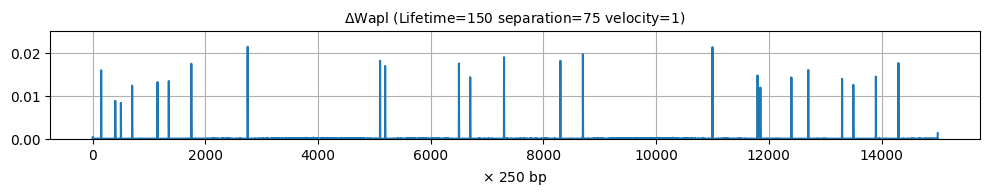

In [29]:
paramdicts = {
    'lifetime':150,
    'separation':75,
    'facestall':0.9,
    'backstall':0.9,
    'stalltime':0.0,
    'stalloftime':10,
    'stalldist':10,
    'steps':200,
    'velocity_multiplier':1,
    'sites_per_monomer':10,
    'monomer_per_replica':1500,
    'replication_number':10
}
N1 = paramdict['monomer_per_replica']

mapN= N1
numx,numy = 1,1
min_time = 1000
c=0
hist_dict = {}


facestalls=[0.9]
stalltimes = [0.0]
stalloftimes = [10]
sites_per_monomers = [1, 10]


    
###################
def peak_positions(lst, window_sizes=[1]):
    peak_monomers = np.array([])
    for i in window_sizes:
        inds_to_add=[lst[j]+i for j in range(len(lst))]
        peak_monomers = np.hstack((peak_monomers,inds_to_add))
    return peak_monomers.astype(int)

def FRiP(num_monomers, lef_positions, num_replica,peak_positions ):
    
    a,b = np.histogram(  lef_positions  , np.arange(num_monomers) )
    return np.sum(a[peak_positions] )/(len(lef_positions)/num_replica)
###################


plt.figure(figsize=(10,5))
for facestall in facestalls:
    paramdicts['facestall'] = facestall
    for stalltime in stalltimes:
        paramdicts['stalltime']=stalltime
        for stalloftime in stalloftimes:
            paramdicts['stalloftime']=stalloftime
            for sites_per_monomer in sites_per_monomers:
                paramdicts['sites_per_monomer']=sites_per_monomer
                file_name = paramdict_to_filename(paramdicts)
                folder_name = '/folder_for_samples/sims/'+'folder_' + file_name.split('file_')[1]
                folder = os.getcwd() + folder_name
                print(folder)
                
                if os.path.exists(folder):
                    c+=1
                    plt.subplot(3,1, c)
                    print("folder exist")
                    with  h5py.File(folder+"/LEFPositions.h5", mode='r') as myfile:
                        lefs = np.array(myfile['positions'])
                        #print(lefs)
                        lef_lefts = lefs[min_time:,:,0].flatten()
                        lef_rights = lefs[min_time:,:,1].flatten()
                        lef_positions = np.hstack((lef_lefts,lef_rights))
                        mapN = N1 * sites_per_monomer
                        a,b = np.histogram(  np.mod( np.hstack((lef_lefts,lef_rights)) , mapN ), np.arange(0,mapN,1))
                        
                        window_size=0
                        
                        
                        
                        RightstallList_m = [15, 50,115, 175,519,670,830,1100,1180,1270,1350,1430]
                        LeftstallList_m = [40,70,135,275,510,650,730,870,1185,1240,1330,1390]
                        RightstallList = [RightstallList_m[i]*paramdicts['sites_per_monomer'] for i in range(len(RightstallList_m))]
                        LeftstallList = [LeftstallList_m[i] * paramdicts['sites_per_monomer'] for i in range(len(LeftstallList_m))]
                        lst= list(np.sort(RightstallList + LeftstallList))
                        
                        
                        
                        peak_monomers = peak_positions(lst,window_sizes=np.arange(-window_size,window_size+1) )
                        
                        
                        
                        Frip_sco=FRiP(mapN, lef_positions, 10,peak_monomers)
                        #print(len(lef_positions)/np.sum(a))
                        print(Frip_sco)
                        plt.plot(a/np.sum(a))
                        plt.ylim([0,.0251])
                        #plt.xlim(0,300)
                        plt.grid(True)
                        #hist_dict[name] = a/np.sum(a)
                        plt.title(r'$\Delta$Wapl (Lifetime=%s separation=%s velocity=%s)'%(paramdicts['lifetime']
                                                                                                ,paramdicts['separation']
                                                                                                ,paramdicts['velocity_multiplier']
                                                                                                ),fontsize=10)
                        plt.xlabel(r'$\times$ 250 bp')
                        
                    plt.tight_layout()    
    

/home1/rahmanin/start/polychrom/simulations_with_ratio/lattice/folder_for_samples/sims/folder_1_lif_150_sep_75_fac_0.9_bac_0.0_sta_0.0_sta_10_sta_10_ste_200_vel_1_sit_1_mon_1500_rep_10
1
/home1/rahmanin/start/polychrom/simulations_with_ratio/lattice/folder_for_samples/sims/folder_1_lif_150_sep_75_fac_0.9_bac_0.0_sta_0.0_sta_10_sta_10_ste_200_vel_1_sit_10_mon_1500_rep_10
1
folder exist
0.5164623737373737
/home1/rahmanin/start/polychrom/simulations_with_ratio/lattice/folder_for_samples/sims/folder_2_lif_150_sep_75_fac_0.9_bac_0.0_sta_0.0_sta_10_sta_10_ste_200_vel_1_sit_1_mon_1500_rep_10
2
/home1/rahmanin/start/polychrom/simulations_with_ratio/lattice/folder_for_samples/sims/folder_2_lif_150_sep_75_fac_0.9_bac_0.0_sta_0.0_sta_10_sta_10_ste_200_vel_1_sit_10_mon_1500_rep_10
2
folder exist
0.4069684343434343
/home1/rahmanin/start/polychrom/simulations_with_ratio/lattice/folder_for_samples/sims/folder_3_lif_150_sep_75_fac_0.9_bac_0.0_sta_0.0_sta_10_sta_10_ste_200_vel_1_sit_1_mon_1500_rep_10
3

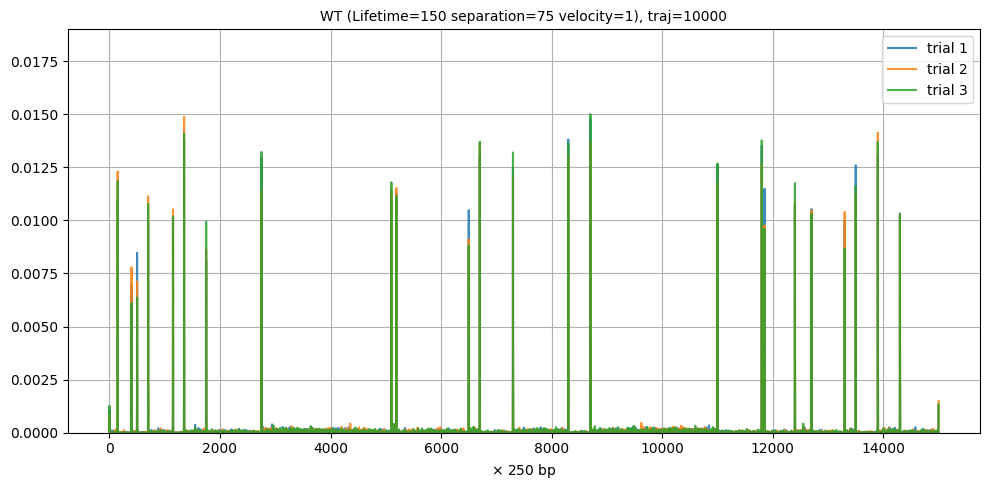

In [87]:
paramdicts = {
    'lifetime':150,
    'separation':75,
    'facestall':0.9,
    'backstall':0.0,
    'stalltime':0.0,
    'stalloftime':10,
    'stalldist':10,
    'steps':200,
    'velocity_multiplier':1,
    'sites_per_monomer':10,
    'monomer_per_replica':1500,
    'replication_number':10
}
N1 = paramdict['monomer_per_replica']

mapN= N1
numx,numy = 1,1
min_time = 1000
c=0
hist_dict = {}


facestalls=[0.9]
stalltimes = [0.0]
stalloftimes = [10]
sites_per_monomers = [1, 10]


    
###################
def peak_positions(lst, window_sizes=[1]):
    peak_monomers = np.array([])
    for i in window_sizes:
        inds_to_add=[lst[j]+i for j in range(len(lst))]
        peak_monomers = np.hstack((peak_monomers,inds_to_add))
    return peak_monomers.astype(int)

def FRiP(num_monomers, lef_positions, num_replica,peak_positions ):
    
    a,b = np.histogram(  lef_positions  , np.arange(num_monomers) )
    return np.sum(a[peak_positions] )/(len(lef_positions)/num_replica)
###################


plt.figure(figsize=(10,5))
for s in range(3):
    for facestall in facestalls:
        paramdicts['facestall'] = facestall
        for stalltime in stalltimes:
            paramdicts['stalltime']=stalltime
            for stalloftime in stalloftimes:
                paramdicts['stalloftime']=stalloftime
                for sites_per_monomer in sites_per_monomers:
                    paramdicts['sites_per_monomer']=sites_per_monomer
                    file_name = paramdict_to_filename(paramdicts)
                    folder_name = '/folder_for_samples/sims/'+'folder_%s_'%(s+1) + file_name.split('file_')[1]
                    folder = os.getcwd() + folder_name
                    print(folder)
                    print(s+1)
                    if os.path.exists(folder):
                        c+=1
                        #plt.subplot(1,1, c)
                        print("folder exist")
                        with  h5py.File(folder+"/LEFPositions.h5", mode='r') as myfile:
                            lefs = np.array(myfile['positions'])
                            #print(lefs)
                            lef_lefts = lefs[min_time:,:,0].flatten()
                            lef_rights = lefs[min_time:,:,1].flatten()
                            lef_positions = np.hstack((lef_lefts,lef_rights))
                            mapN = N1 * sites_per_monomer
                            a,b = np.histogram(  np.mod( np.hstack((lef_lefts,lef_rights)) , mapN ), np.arange(0,mapN,1))

                            window_size=0



                            RightstallList_m = [15, 50,115, 175,519,670,830,1100,1180,1270,1350,1430]
                            LeftstallList_m = [40,70,135,275,510,650,730,870,1185,1240,1330,1390]
                            RightstallList = [RightstallList_m[i]*paramdicts['sites_per_monomer'] for i in range(len(RightstallList_m))]
                            LeftstallList = [LeftstallList_m[i] * paramdicts['sites_per_monomer'] for i in range(len(LeftstallList_m))]
                            lst= list(np.sort(RightstallList + LeftstallList))


                            window_size=int(paramdicts['sites_per_monomer']/2)
                            #window_size=0
                            peak_monomers = peak_positions(lst,window_sizes=np.arange(-window_size,window_size+1) )



                            Frip_sco=FRiP(mapN, lef_positions, 10,peak_monomers)
                            print(Frip_sco)
                            #print(len(lef_positions)/np.sum(a))
                            plt.plot(a/np.sum(a),label='trial %s'%(s+1),alpha=0.85)
plt.ylim([0,.019])
                            #plt.xlim(0,300)
plt.grid(True)
                            #hist_dict[name] = a/np.sum(a)
plt.title('WT (Lifetime=%s separation=%s velocity=%s), traj=10000'%(paramdicts['lifetime'],paramdicts['separation'],paramdicts['velocity_multiplier']),fontsize=10)
                        #plt.title('Lifetime=%s separation=%s velocity=%s sites_per_monomer=%s Frip=%0.3f window size=%s'%(paramdicts['lifetime']
                        #                                                                            ,paramdicts['separation']
                        #                                                                            ,paramdicts['velocity_multiplier']
                        #                                                                            ,paramdicts['sites_per_monomer']
                        #                                                                            ,Frip_sco, window_size+1),fontsize=10)
plt.legend()
plt.xlabel(r'$\times$ 250 bp')
plt.tight_layout()    
plt.show()                    

/home1/rahmanin/start/polychrom/simulations_with_ratio/lattice/folder_for_samples/sims/folder_lif_50_sep_100_fac_0.9_bac_0.0_sta_0.0_sta_10_sta_10_ste_200_vel_3_sit_1_mon_1500_rep_10
folder exist
/home1/rahmanin/start/polychrom/simulations_with_ratio/lattice/folder_for_samples/sims/folder_lif_50_sep_100_fac_0.9_bac_0.0_sta_0.0_sta_10_sta_10_ste_200_vel_3_sit_10_mon_1500_rep_10
folder exist


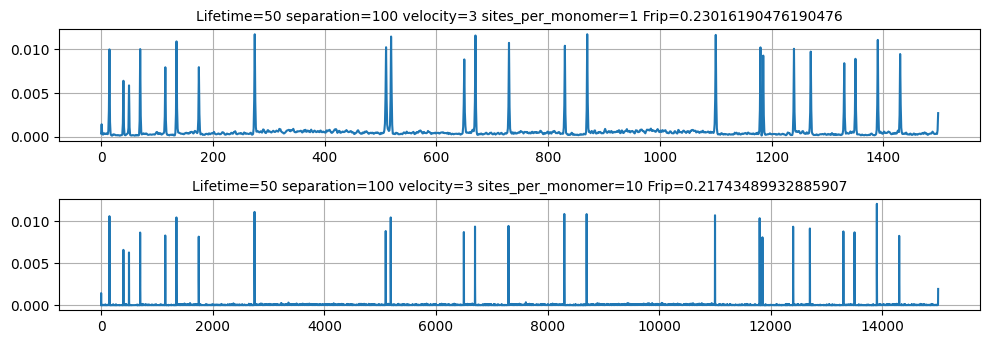

In [94]:
paramdicts = {
    'lifetime':50,
    'separation':100,
    'facestall':0.9,
    'backstall':0.0,
    'stalltime':0.0,
    'stalloftime':10,
    'stalldist':10,
    'steps':200,
    'velocity_multiplier':3,
    'sites_per_monomer':10,
    'monomer_per_replica':1500,
    'replication_number':10
}
N1 = paramdict['monomer_per_replica']

mapN= N1
numx,numy = 1,1
min_time = 1000
c=0
hist_dict = {}


facestalls=[0.9]
stalltimes = [0.0]
stalloftimes = [10]
sites_per_monomers = [1, 10]


    
###################
def peak_positions(lst, window_sizes=[1]):
    peak_monomers = np.array([])
    for i in window_sizes:
        inds_to_add=[lst[j]+i for j in range(len(lst))]
        peak_monomers = np.hstack((peak_monomers,inds_to_add))
    return peak_monomers.astype(int)

def FRiP(num_monomers, lef_positions, num_replica,peak_positions ):
    
    a,b = np.histogram(  lef_positions  , np.arange(num_monomers) )
    return np.sum(a[peak_positions] )/(len(lef_positions)/num_replica)
###################


plt.figure(figsize=(10,5))
for facestall in facestalls:
    paramdicts['facestall'] = facestall
    for stalltime in stalltimes:
        paramdicts['stalltime']=stalltime
        for stalloftime in stalloftimes:
            paramdicts['stalloftime']=stalloftime
            for sites_per_monomer in sites_per_monomers:
                paramdicts['sites_per_monomer']=sites_per_monomer
                file_name = paramdict_to_filename(paramdicts)
                folder_name = '/folder_for_samples/sims/'+'folder_' + file_name.split('file_')[1]
                folder = os.getcwd() + folder_name
                print(folder)
                
                if os.path.exists(folder):
                    c+=1
                    plt.subplot(3,1, c)
                    print("folder exist")
                    with  h5py.File(folder+"/LEFPositions.h5", mode='r') as myfile:
                        lefs = np.array(myfile['positions'])
                        #print(lefs)
                        lef_lefts = lefs[min_time:,:,0].flatten()
                        lef_rights = lefs[min_time:,:,1].flatten()
                        lef_positions = np.hstack((lef_lefts,lef_rights))
                        mapN = N1 * sites_per_monomer
                        a,b = np.histogram(  np.mod( np.hstack((lef_lefts,lef_rights)) , mapN ), np.arange(0,mapN,1))
                        
                        window_size=0
                        
                        
                        
                        RightstallList_m = [15, 50,115, 175,519,670,830,1100,1180,1270,1350,1430]
                        LeftstallList_m = [40,70,135,275,510,650,730,870,1185,1240,1330,1390]
                        RightstallList = [RightstallList_m[i]*paramdicts['sites_per_monomer'] for i in range(len(RightstallList_m))]
                        LeftstallList = [LeftstallList_m[i] * paramdicts['sites_per_monomer'] for i in range(len(LeftstallList_m))]
                        lst= list(np.sort(RightstallList + LeftstallList))
                        
                        
                        
                        peak_monomers = peak_positions(lst,window_sizes=np.arange(-window_size,window_size+1) )
                        
                        
                        
                        Frip_sco=FRiP(mapN, lef_positions, 10,peak_monomers)
                        #print(len(lef_positions)/np.sum(a))
                        plt.plot(a/np.sum(a))
                        #plt.ylim([0,.019])
                        #plt.xlim(0,300)
                        plt.grid(True)
                        #hist_dict[name] = a/np.sum(a)
                        plt.title('Lifetime=%s separation=%s velocity=%s sites_per_monomer=%s Frip=%s'%(paramdicts['lifetime']
                                                                                                ,paramdicts['separation']
                                                                                                ,paramdicts['velocity_multiplier']
                                                                                                ,paramdicts['sites_per_monomer']
                                                                                                ,Frip_sco),fontsize=10)
                        
                    plt.tight_layout()    
    

/home1/rahmanin/start/polychrom/simulations_with_ratio/lattice/folder_for_samples/sims/folder_lif_150_sep_100_fac_0.9_bac_0.0_sta_0.0_sta_10_sta_10_ste_200_vel_3_sit_1_mon_1500_rep_10
folder exist
/home1/rahmanin/start/polychrom/simulations_with_ratio/lattice/folder_for_samples/sims/folder_lif_150_sep_100_fac_0.9_bac_0.0_sta_0.0_sta_10_sta_10_ste_200_vel_3_sit_10_mon_1500_rep_10
folder exist


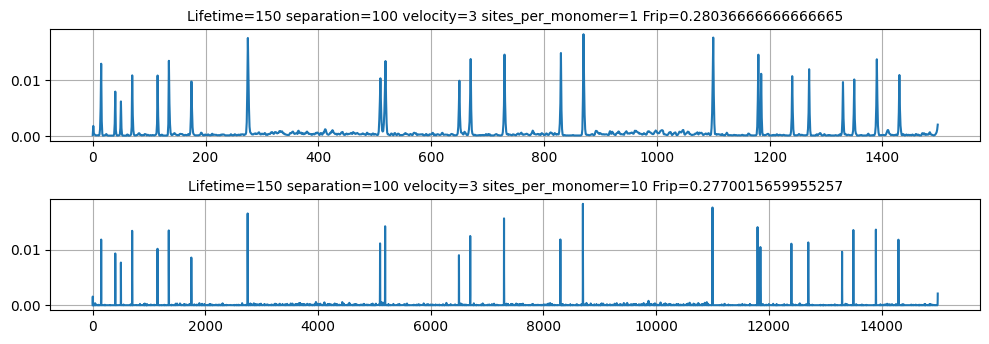

In [93]:
paramdicts = {
    'lifetime':150,
    'separation':100,
    'facestall':0.9,
    'backstall':0.0,
    'stalltime':0.0,
    'stalloftime':10,
    'stalldist':10,
    'steps':200,
    'velocity_multiplier':3,
    'sites_per_monomer':10,
    'monomer_per_replica':1500,
    'replication_number':10
}
N1 = paramdict['monomer_per_replica']

mapN= N1
numx,numy = 1,1
min_time = 1000
c=0
hist_dict = {}


facestalls=[0.9]
stalltimes = [0.0]
stalloftimes = [10]
sites_per_monomers = [1, 10]


    
###################
def peak_positions(lst, window_sizes=[1]):
    peak_monomers = np.array([])
    for i in window_sizes:
        inds_to_add=[lst[j]+i for j in range(len(lst))]
        peak_monomers = np.hstack((peak_monomers,inds_to_add))
    return peak_monomers.astype(int)

def FRiP(num_monomers, lef_positions, num_replica,peak_positions ):
    
    a,b = np.histogram(  lef_positions  , np.arange(num_monomers) )
    return np.sum(a[peak_positions] )/(len(lef_positions)/num_replica)
###################


plt.figure(figsize=(10,5))
for facestall in facestalls:
    paramdicts['facestall'] = facestall
    for stalltime in stalltimes:
        paramdicts['stalltime']=stalltime
        for stalloftime in stalloftimes:
            paramdicts['stalloftime']=stalloftime
            for sites_per_monomer in sites_per_monomers:
                paramdicts['sites_per_monomer']=sites_per_monomer
                file_name = paramdict_to_filename(paramdicts)
                folder_name = '/folder_for_samples/sims/'+'folder_' + file_name.split('file_')[1]
                folder = os.getcwd() + folder_name
                print(folder)
                
                if os.path.exists(folder):
                    c+=1
                    plt.subplot(3,1, c)
                    print("folder exist")
                    with  h5py.File(folder+"/LEFPositions.h5", mode='r') as myfile:
                        lefs = np.array(myfile['positions'])
                        #print(lefs)
                        lef_lefts = lefs[min_time:,:,0].flatten()
                        lef_rights = lefs[min_time:,:,1].flatten()
                        lef_positions = np.hstack((lef_lefts,lef_rights))
                        mapN = N1 * sites_per_monomer
                        a,b = np.histogram(  np.mod( np.hstack((lef_lefts,lef_rights)) , mapN ), np.arange(0,mapN,1))
                        
                        window_size=0
                        
                        
                        
                        RightstallList_m = [15, 50,115, 175,519,670,830,1100,1180,1270,1350,1430]
                        LeftstallList_m = [40,70,135,275,510,650,730,870,1185,1240,1330,1390]
                        RightstallList = [RightstallList_m[i]*paramdicts['sites_per_monomer'] for i in range(len(RightstallList_m))]
                        LeftstallList = [LeftstallList_m[i] * paramdicts['sites_per_monomer'] for i in range(len(LeftstallList_m))]
                        lst= list(np.sort(RightstallList + LeftstallList))
                        
                        
                        
                        peak_monomers = peak_positions(lst,window_sizes=np.arange(-window_size,window_size+1) )
                        
                        
                        
                        Frip_sco=FRiP(mapN, lef_positions, 10,peak_monomers)
                        #print(len(lef_positions)/np.sum(a))
                        plt.plot(a/np.sum(a))
                        #plt.ylim([0,.019])
                        #plt.xlim(0,300)
                        plt.grid(True)
                        #hist_dict[name] = a/np.sum(a)
                        plt.title('Lifetime=%s separation=%s velocity=%s sites_per_monomer=%s Frip=%s'%(paramdicts['lifetime']
                                                                                                ,paramdicts['separation']
                                                                                                ,paramdicts['velocity_multiplier']
                                                                                                ,paramdicts['sites_per_monomer']
                                                                                                ,Frip_sco),fontsize=10)
                        
                    plt.tight_layout()    
    

0.27854464285714287
0.5911169463087248


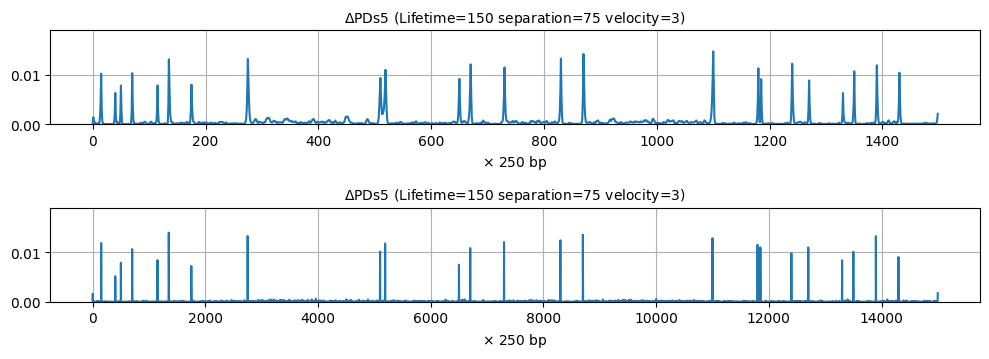

In [59]:
paramdicts = {
    'lifetime':150,
    'separation':75,
    'facestall':0.9,
    'backstall':0.0,
    'stalltime':0.0,
    'stalloftime':10,
    'stalldist':10,
    'steps':200,
    'velocity_multiplier':3,
    'sites_per_monomer':10,
    'monomer_per_replica':1500,
    'replication_number':10
}
N1 = paramdict['monomer_per_replica']

mapN= N1
numx,numy = 1,1
min_time = 1000
c=0
hist_dict = {}


facestalls=[0.9]
stalltimes = [0.0]
stalloftimes = [10]
sites_per_monomers = [1, 10]


    
###################
def peak_positions(lst, window_sizes=[1]):
    peak_monomers = np.array([])
    for i in window_sizes:
        inds_to_add=[lst[j]+i for j in range(len(lst))]
        peak_monomers = np.hstack((peak_monomers,inds_to_add))
    return peak_monomers.astype(int)

def FRiP(num_monomers, lef_positions, num_replica,peak_positions ):
    
    a,b = np.histogram(  lef_positions  , np.arange(num_monomers) )
    return np.sum(a[peak_positions] )/(len(lef_positions)/num_replica)
###################


plt.figure(figsize=(10,5))
for facestall in facestalls:
    paramdicts['facestall'] = facestall
    for stalltime in stalltimes:
        paramdicts['stalltime']=stalltime
        for stalloftime in stalloftimes:
            paramdicts['stalloftime']=stalloftime
            for sites_per_monomer in sites_per_monomers:
                paramdicts['sites_per_monomer']=sites_per_monomer
                file_name = paramdict_to_filename(paramdicts)
                folder_name = '/folder_for_samples/sims/'+'folder_' + file_name.split('file_')[1]
                folder = os.getcwd() + folder_name
                #print(folder)
                
                if os.path.exists(folder):
                    c+=1
                    plt.subplot(3,1, c)
                    #print("folder exist")
                    with  h5py.File(folder+"/LEFPositions.h5", mode='r') as myfile:
                        lefs = np.array(myfile['positions'])
                        #print(lefs)
                        lef_lefts = lefs[min_time:,:,0].flatten()
                        lef_rights = lefs[min_time:,:,1].flatten()
                        lef_positions = np.hstack((lef_lefts,lef_rights))
                        mapN = N1 * sites_per_monomer
                        a,b = np.histogram(  np.mod( np.hstack((lef_lefts,lef_rights)) , mapN ), np.arange(0,mapN,1))
                        
                        window_size=0
                        
                        
                        
                        RightstallList_m = [15, 50,115, 175,519,670,830,1100,1180,1270,1350,1430]
                        LeftstallList_m = [40,70,135,275,510,650,730,870,1185,1240,1330,1390]
                        RightstallList = [RightstallList_m[i]*paramdicts['sites_per_monomer'] for i in range(len(RightstallList_m))]
                        LeftstallList = [LeftstallList_m[i] * paramdicts['sites_per_monomer'] for i in range(len(LeftstallList_m))]
                        lst= list(np.sort(RightstallList + LeftstallList))
                        
                        
                        window_size=int(paramdicts['sites_per_monomer']/2)
                        peak_monomers = peak_positions(lst,window_sizes=np.arange(-window_size,window_size+1) )
                        #print(peak_monomers)
                        
                        
                        
                        Frip_sco=FRiP(mapN, lef_positions, 10,peak_monomers)
                        #print(len(lef_positions)/np.sum(a))
                        print(Frip_sco)
                        plt.plot(a/np.sum(a))
                        plt.ylim([0,.019])
                        #plt.xlim(0,300)
                        plt.grid(True)
                        #hist_dict[name] = a/np.sum(a)
                        plt.title(r'$\Delta$PDs5 (Lifetime=%s separation=%s velocity=%s)'%(paramdicts['lifetime']
                                                                                                ,paramdicts['separation']
                                                                                                ,paramdicts['velocity_multiplier']
                                                                                                ),fontsize=10)
                        plt.xlabel(r'$\times$ 250 bp')
                    plt.tight_layout()    
    

0.6774640939597315


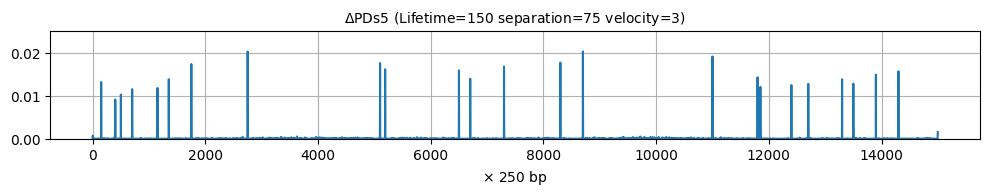

In [31]:
paramdicts = {
    'lifetime':150,
    'separation':75,
    'facestall':0.9,
    'backstall':0.9,
    'stalltime':0.0,
    'stalloftime':10,
    'stalldist':10,
    'steps':200,
    'velocity_multiplier':3,
    'sites_per_monomer':10,
    'monomer_per_replica':1500,
    'replication_number':10
}
N1 = paramdict['monomer_per_replica']

mapN= N1
numx,numy = 1,1
min_time = 1000
c=0
hist_dict = {}


facestalls=[0.9]
stalltimes = [0.0]
stalloftimes = [10]
sites_per_monomers = [1, 10]


    
###################
def peak_positions(lst, window_sizes=[1]):
    peak_monomers = np.array([])
    for i in window_sizes:
        inds_to_add=[lst[j]+i for j in range(len(lst))]
        peak_monomers = np.hstack((peak_monomers,inds_to_add))
    return peak_monomers.astype(int)

def FRiP(num_monomers, lef_positions, num_replica,peak_positions ):
    
    a,b = np.histogram(  lef_positions  , np.arange(num_monomers) )
    return np.sum(a[peak_positions] )/(len(lef_positions)/num_replica)
###################


plt.figure(figsize=(10,5))
for facestall in facestalls:
    paramdicts['facestall'] = facestall
    for stalltime in stalltimes:
        paramdicts['stalltime']=stalltime
        for stalloftime in stalloftimes:
            paramdicts['stalloftime']=stalloftime
            for sites_per_monomer in sites_per_monomers:
                paramdicts['sites_per_monomer']=sites_per_monomer
                file_name = paramdict_to_filename(paramdicts)
                folder_name = '/folder_for_samples/sims/'+'folder_' + file_name.split('file_')[1]
                folder = os.getcwd() + folder_name
                #print(folder)
                
                if os.path.exists(folder):
                    c+=1
                    plt.subplot(3,1, c)
                    #print("folder exist")
                    with  h5py.File(folder+"/LEFPositions.h5", mode='r') as myfile:
                        lefs = np.array(myfile['positions'])
                        #print(lefs)
                        lef_lefts = lefs[min_time:,:,0].flatten()
                        lef_rights = lefs[min_time:,:,1].flatten()
                        lef_positions = np.hstack((lef_lefts,lef_rights))
                        mapN = N1 * sites_per_monomer
                        a,b = np.histogram(  np.mod( np.hstack((lef_lefts,lef_rights)) , mapN ), np.arange(0,mapN,1))
                        
                        window_size=0
                        
                        
                        
                        RightstallList_m = [15, 50,115, 175,519,670,830,1100,1180,1270,1350,1430]
                        LeftstallList_m = [40,70,135,275,510,650,730,870,1185,1240,1330,1390]
                        RightstallList = [RightstallList_m[i]*paramdicts['sites_per_monomer'] for i in range(len(RightstallList_m))]
                        LeftstallList = [LeftstallList_m[i] * paramdicts['sites_per_monomer'] for i in range(len(LeftstallList_m))]
                        lst= list(np.sort(RightstallList + LeftstallList))
                        
                        
                        window_size=int(paramdicts['sites_per_monomer']/2)
                        peak_monomers = peak_positions(lst,window_sizes=np.arange(-window_size,window_size+1) )
                        #print(peak_monomers)
                        
                        
                        
                        Frip_sco=FRiP(mapN, lef_positions, 10,peak_monomers)
                        #print(len(lef_positions)/np.sum(a))
                        print(Frip_sco)
                        plt.plot(a/np.sum(a))
                        plt.ylim([0,.0251])
                        #plt.xlim(0,300)
                        plt.grid(True)
                        #hist_dict[name] = a/np.sum(a)
                        plt.title(r'$\Delta$PDs5 (Lifetime=%s separation=%s velocity=%s)'%(paramdicts['lifetime']
                                                                                                ,paramdicts['separation']
                                                                                                ,paramdicts['velocity_multiplier']
                                                                                                ),fontsize=10)
                        plt.xlabel(r'$\times$ 250 bp')
                    plt.tight_layout()    
    

/home1/rahmanin/start/polychrom/simulations_with_ratio/lattice/folder_for_samples/sims/folder_1_lif_150_sep_75_fac_0.9_bac_0.0_sta_0.0_sta_10_sta_10_ste_200_vel_3_sit_1_mon_1500_rep_10
1
/home1/rahmanin/start/polychrom/simulations_with_ratio/lattice/folder_for_samples/sims/folder_1_lif_150_sep_75_fac_0.9_bac_0.0_sta_0.0_sta_10_sta_10_ste_200_vel_3_sit_10_mon_1500_rep_10
1
folder exist
0.5832195652173913
/home1/rahmanin/start/polychrom/simulations_with_ratio/lattice/folder_for_samples/sims/folder_2_lif_150_sep_75_fac_0.9_bac_0.0_sta_0.0_sta_10_sta_10_ste_200_vel_3_sit_1_mon_1500_rep_10
2
/home1/rahmanin/start/polychrom/simulations_with_ratio/lattice/folder_for_samples/sims/folder_2_lif_150_sep_75_fac_0.9_bac_0.0_sta_0.0_sta_10_sta_10_ste_200_vel_3_sit_10_mon_1500_rep_10
2
folder exist
0.5538086120401338
/home1/rahmanin/start/polychrom/simulations_with_ratio/lattice/folder_for_samples/sims/folder_3_lif_150_sep_75_fac_0.9_bac_0.0_sta_0.0_sta_10_sta_10_ste_200_vel_3_sit_1_mon_1500_rep_10
3

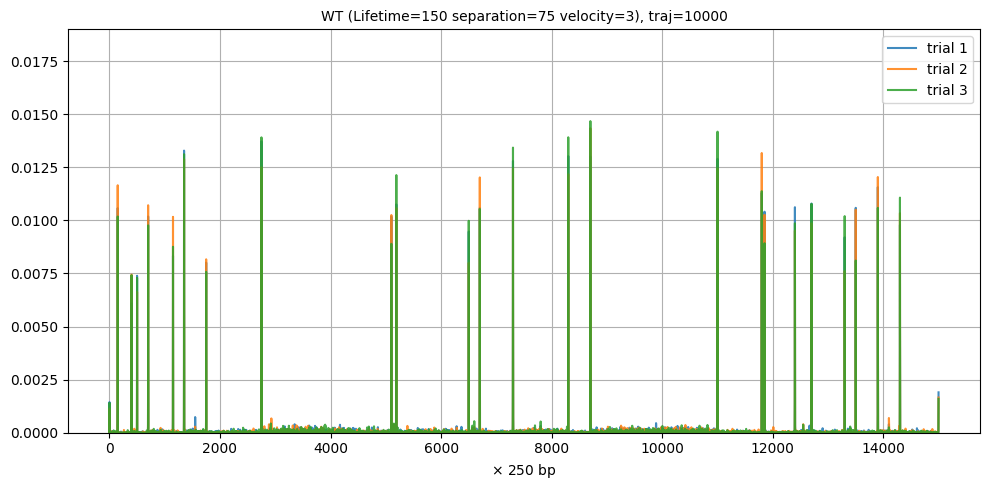

In [23]:
paramdicts = {
    'lifetime':150,
    'separation':75,
    'facestall':0.9,
    'backstall':0.0,
    'stalltime':0.0,
    'stalloftime':10,
    'stalldist':10,
    'steps':200,
    'velocity_multiplier':3,
    'sites_per_monomer':10,
    'monomer_per_replica':1500,
    'replication_number':10
}
N1 = paramdict['monomer_per_replica']

mapN= N1
numx,numy = 1,1
min_time = 1000
c=0
hist_dict = {}


facestalls=[0.9]
stalltimes = [0.0]
stalloftimes = [10]
sites_per_monomers = [1, 10]


    
###################
def peak_positions(lst, window_sizes=[1]):
    peak_monomers = np.array([])
    for i in window_sizes:
        inds_to_add=[lst[j]+i for j in range(len(lst))]
        peak_monomers = np.hstack((peak_monomers,inds_to_add))
    return peak_monomers.astype(int)

def FRiP(num_monomers, lef_positions, num_replica,peak_positions ):
    
    a,b = np.histogram(  lef_positions  , np.arange(num_monomers) )
    return np.sum(a[peak_positions] )/(len(lef_positions)/num_replica)
###################


plt.figure(figsize=(10,5))
for s in range(3):
    for facestall in facestalls:
        paramdicts['facestall'] = facestall
        for stalltime in stalltimes:
            paramdicts['stalltime']=stalltime
            for stalloftime in stalloftimes:
                paramdicts['stalloftime']=stalloftime
                for sites_per_monomer in sites_per_monomers:
                    paramdicts['sites_per_monomer']=sites_per_monomer
                    file_name = paramdict_to_filename(paramdicts)
                    folder_name = '/folder_for_samples/sims/'+'folder_%s_'%(s+1) + file_name.split('file_')[1]
                    folder = os.getcwd() + folder_name
                    print(folder)
                    print(s+1)
                    if os.path.exists(folder):
                        c+=1
                        #plt.subplot(1,1, c)
                        print("folder exist")
                        with  h5py.File(folder+"/LEFPositions.h5", mode='r') as myfile:
                            lefs = np.array(myfile['positions'])
                            #print(lefs)
                            lef_lefts = lefs[min_time:,:,0].flatten()
                            lef_rights = lefs[min_time:,:,1].flatten()
                            lef_positions = np.hstack((lef_lefts,lef_rights))
                            mapN = N1 * sites_per_monomer
                            a,b = np.histogram(  np.mod( np.hstack((lef_lefts,lef_rights)) , mapN ), np.arange(0,mapN,1))

                            window_size=0



                            RightstallList_m = [15, 50,115, 175,519,670,830,1100,1180,1270,1350,1430]
                            LeftstallList_m = [40,70,135,275,510,650,730,870,1185,1240,1330,1390]
                            RightstallList = [RightstallList_m[i]*paramdicts['sites_per_monomer'] for i in range(len(RightstallList_m))]
                            LeftstallList = [LeftstallList_m[i] * paramdicts['sites_per_monomer'] for i in range(len(LeftstallList_m))]
                            lst= list(np.sort(RightstallList + LeftstallList))


                            window_size=int(paramdicts['sites_per_monomer']/2)
                            #window_size=0
                            peak_monomers = peak_positions(lst,window_sizes=np.arange(-window_size,window_size+1) )



                            Frip_sco=FRiP(mapN, lef_positions, 10,peak_monomers)
                            print(Frip_sco)
                            #print(len(lef_positions)/np.sum(a))
                            plt.plot(a/np.sum(a),label='trial %s'%(s+1),alpha=0.85)
plt.ylim([0,.019])
                            #plt.xlim(0,300)
plt.grid(True)
                            #hist_dict[name] = a/np.sum(a)
plt.title('WT (Lifetime=%s separation=%s velocity=%s), traj=10000'%(paramdicts['lifetime'],paramdicts['separation'],paramdicts['velocity_multiplier']),fontsize=10)
                        #plt.title('Lifetime=%s separation=%s velocity=%s sites_per_monomer=%s Frip=%0.3f window size=%s'%(paramdicts['lifetime']
                        #                                                                            ,paramdicts['separation']
                        #                                                                            ,paramdicts['velocity_multiplier']
                        #                                                                            ,paramdicts['sites_per_monomer']
                        #                                                                            ,Frip_sco, window_size+1),fontsize=10)
plt.legend()
plt.xlabel(r'$\times$ 250 bp')
plt.tight_layout()    
plt.show()                    

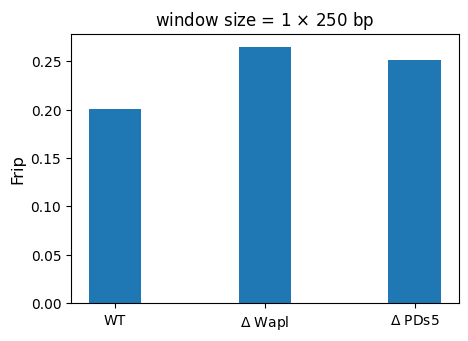

In [62]:
x =['WT',r'$\Delta$ Wapl',r'$\Delta$ PDs5']
y= [0.201,0.265,0.251]#0.2011192393736018, 0.26490687919463085, 0.25173422818791946
plt.figure(figsize=(5,3.5))
plt.bar(x,y,width=.35)
plt.title(r'window size = 1 $\times$ 250 bp')
plt.ylabel('Frip',fontsize=11.75)
plt.show()


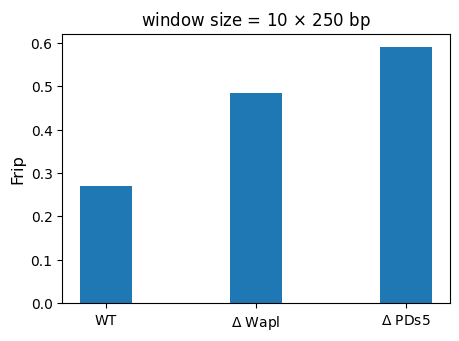

In [63]:
x =['WT',r'$\Delta$ Wapl',r'$\Delta$ PDs5']
y= [0.269,0.484,0.591]#0.2687917225950783, 0.48449597315436244, 0.5911169463087248
plt.figure(figsize=(5,3.5))
plt.bar(x,y,width=0.35)
plt.ylabel('Frip',fontsize=11.75)
plt.title(r'window size = 10 $\times$ 250 bp')

plt.show()

In [110]:
int(10/2)

5

In [68]:
lst_t=[lst[i]*10 for i in range(len(lst))]
print(lst, lst_t)

[15, 40, 50, 70, 115, 135, 175, 275, 510, 519, 650, 670, 730, 830, 870, 1100, 1180, 1185, 1240, 1270, 1330, 1350, 1390, 1430] [150, 400, 500, 700, 1150, 1350, 1750, 2750, 5100, 5190, 6500, 6700, 7300, 8300, 8700, 11000, 11800, 11850, 12400, 12700, 13300, 13500, 13900, 14300]


### Md simulation

In [25]:
folder_name = folder
myfile = h5py.File(folder_name+"/LEFPositions.h5", mode='r')
N = myfile.attrs["N"] #number of monomers   //Sites_per_monomer
LEFNum = myfile.attrs["LEFNum"]   #number of extruders
LEFpositions = myfile["positions"][::Sites_per_monomer]// Sites_per_monomer
print(N, LEFNum)

# -------defining MD parameters----------
stiff = 1
dens = 0.2
box = (N / dens) ** 0.33  # density = 0.1.


Nframes = LEFpositions.shape[0]
data = grow_cubic(N, int(box) - 2)  # creates a compact conformation 
block = 0  # starting block 

# new parameters because some things changed 
saveEveryBlocks = 10   # save every 10 blocks (saving every block is now too much almost)
restartSimulationEveryBlocks = 100

# parameters for smc bonds
smcBondWiggleDist = 0.2
smcBondDist = 0.5

# assertions for easy managing code below 
assert (Nframes % restartSimulationEveryBlocks) == 0 
assert (restartSimulationEveryBlocks % saveEveryBlocks) == 0

savesPerSim = restartSimulationEveryBlocks // saveEveryBlocks
simInitsTotal  = (Nframes) // restartSimulationEveryBlocks 


tstp = 70 # timestep for integrator in fs
tmst = 0.01 # thermostat for integrator

milker = polychrom.lib.extrusion.bondUpdater(LEFpositions)

reporter = HDF5Reporter(folder=folder, max_data_length=100, overwrite=True, blocks_only=False)

for iteration in range(simInitsTotal):
    # simulation parameters are defined below 
    a = Simulation(
            platform="cuda",
            integrator='langevin',  timestep=tstp, collision_rate=tmst,
            error_tol=0.01,  
            GPU="0",
            N = len(data),
            reporters=[reporter],
            PBCbox=[box, box, box],
            precision="mixed")  # timestep not necessary for variableLangevin
    ############################## New code ##############################
    a.set_data(data)  # loads a polymer, puts a center of mass at zero

    a.add_force(
        forcekits.polymer_chains(
            a,
            chains=[(0, None, 0)],

                # By default the library assumes you have one polymer chain
                # If you want to make it a ring, or more than one chain, use self.setChains
                # self.setChains([(0,50,1),(50,None,0)]) will set a 50-monomer ring and a chain from monomer 50 to the end

            bond_force_func=forces.harmonic_bonds,
            bond_force_kwargs={
                'bondLength':1.0,
                'bondWiggleDistance':0.1, # Bond distance will fluctuate +- 0.05 on average
             },

            angle_force_func=forces.angle_force,
            angle_force_kwargs={
                'k':1.5
                # K is more or less arbitrary, k=4 corresponds to presistence length of 4,
                # k=1.5 is recommended to make polymer realistically flexible; k=8 is very stiff
            },

            nonbonded_force_func=forces.polynomial_repulsive,
            nonbonded_force_kwargs={
                'trunc':1.5, # this will let chains cross sometimes
                'radiusMult':1.05, # this is from old code
                #'trunc':10.0, # this will resolve chain crossings and will not let chain cross anymore
            },
            except_bonds=True,
    ))
    # ------------ initializing milker; adding bonds ---------
    # copied from addBond
    kbond = a.kbondScalingFactor / (smcBondWiggleDist ** 2)
    bondDist = smcBondDist * a.length_scale

    activeParams = {"length":bondDist,"k":kbond}
    inactiveParams = {"length":bondDist, "k":0}
    milker.setParams(activeParams, inactiveParams)

    # this step actually puts all bonds in and sets first bonds to be what they should be
    milker.setup(bondForce=a.force_dict['harmonic_bonds'],
                blocks=restartSimulationEveryBlocks)
    print(milker.allBonds[0])
    for t,l in enumerate(milker.allBonds):
        for b in l:
            if (b[0] == 11296) or (b[1] == 11296):
                print(t,b)
    # If your simulation does not start, consider using energy minimization below
    if iteration==0:
        a.local_energy_minimization() 
    else:
        a._apply_forces()

    for i in range(restartSimulationEveryBlocks):        
       # print("restart#",i)
        if i % saveEveryBlocks == (saveEveryBlocks - 1):  
            a.do_block(steps=steps)
        else:
            a.integrator.step(steps)  # do steps without getting the positions from the GPU (faster)
        if i < restartSimulationEveryBlocks - 1: 
            curBonds, pastBonds = milker.step(a.context)  # this updates bonds. You can do something with bonds here
    data = a.get_data()  # save data and step, and delete the simulation
    del a

    reporter.blocks_only = True  # Write output hdf5-files only for blocks

    time.sleep(0.2)  # wait 200ms for sanity (to let garbage collector do its magic)

reporter.dump_data()



myfile.close()



15000 150
Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 14999
[(3802, 3829), (3741, 3747), (14317, 14369), (10455, 10481), (5308, 5322), (12317, 12339), (13390, 13430), (2435, 2594), (9135, 9247), (3261, 3274), (14370, 14423), (12173, 12230), (7185, 7270), (7330, 7350), (4784, 4872), (14567, 14637), (10653, 10666), (6953, 6992), (4079, 4100), (4970, 4978), (4034, 4067), (3670, 3729), (7081, 7180), (5331, 5341), (5167, 5254), (4873, 4905), (6402, 6455), (6510, 6554), (8010, 8093), (9479, 9526), (5260, 5306), (923, 1041), (10357, 10408), (12171, 12222), (13508, 13525), (1207, 1263), (8186, 8229), (8230, 8330), (2956, 2990), (14231, 14316), (2204, 2227), (9235, 9240), (4351, 4357), (831, 886), (14271, 14304), (9136, 9246), (3071, 3175), (10080, 10103), (8044, 8092), (7103, 7126), (7635, 7690), (5418, 5439), (1775, 1890), (12015, 12025), (4894, 4900), (4481, 4550), (136, 174), (14195, 14230), (2078, 2100), (7393, 7419), (9248, 9279), (1279, 1329), (29

In [19]:
myfile = h5py.File(folder_name+"/LEFPositions.h5", mode='r')
N = myfile.attrs["N"]
LEFNum = myfile.attrs["LEFNum"]
print(N)
print(LEFNum)

10000
100


### MD Analysis

In [59]:
mapN = 3000
mapstarts = (np.arange(0, 13500,1500))
#print(mapstarts)
min_time = 0 #It was 750
skip_freq = 5
refresh = True
if refresh== True:
    map_dict_eq = {}
name='SampleLIFETIME_50_SEPARATION_100_RSTALL_0.9_LSTALL_0.0_RC_0.0_LC_0.9_stalldist_1_stalltime_50_stalloftime_1_STEPS_200_velocitymultiplier_1_Tad_1000'
URIs = polychrom.hdf5_format.list_URIs(name)
URIs_eq = np.array(URIs)[np.array([int(i.split("::")[-1]) for i in URIs]) > min_time][::skip_freq]
    #print(URIs_eq)
mrc = polychrom.contactmaps.monomerResolutionContactMapSubchains(
    URIs_eq,
    mapstarts,
    mapN,
    cutoff=2.3,
    n=8)
map_dict_eq[name] = mrc
    

mrc=map_dict_eq[name]
np.savez_compressed('data/%s.npz'%name,mrc)

SampleLIFETIME_50_SEPARATION_100_RSTALL_0.9_LSTALL_0.0_RC_0.0_LC_0.9_stalldist_1_stalltime_50_stalloftime_1_STEPS_200_velocitymultiplier_1_Tad_1000


/home1/rahmanin/.conda/envs/openwpoly/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10


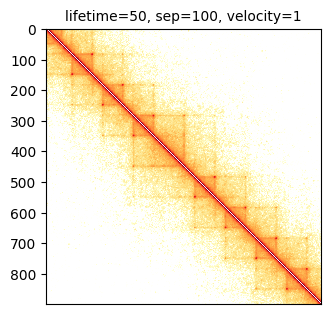

In [61]:
%matplotlib inline
numx,numy =5,15
c=0
subplot_width = 3

plt.figure(figsize=(subplot_width*numx,subplot_width*numy))
folder_name=['SampleLIFETIME_50_SEPARATION_100_RSTALL_0.9_LSTALL_0.0_RC_0.0_LC_0.9_stalldist_1_stalltime_50_stalloftime_1_STEPS_200_velocitymultiplier_1_Tad_1000']
for name in folder_name:#[:-2]:
    print(name)
    params=[ast.literal_eval(i) for i in name.split('_')[1::2]]
    Lifetime,separation, rstall,lstall,rc,lc,stalldist,stalltime,stalloftime,steps,velocity,Tad=params
    c+=1
    plt.subplot(numy,numx, c)

    plt.title('lifetime=%s, sep=%s, velocity=%s'%(Lifetime,separation,velocity),fontsize=10)
    data=np.load('data/%s.npz'%name)
    mrc=data['arr_0']
    #mrc = map_dict_eq[name]
    mrc  = mrc.astype(float)
    mrc /= np.median(np.diag(mrc,2))
    mat = np.log10(mrc)
    vmax = np.median(np.diag(mat,2))
    vmin = vmax - 3
    plt.matshow(mat[1050:1950,1050:1950],vmin=vmin,vmax=vmax,cmap='fall', fignum=False);
    plt.xticks([])
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pylab as plt

import pandas as pd

from matplotlib import rc
from scipy.optimize import curve_fit
from matplotlib import rc

def func(x, a, b, c):
    return a * np.exp(-b * x) +c

lst=[[15,1],[50,1],[150,1],[500,1]]
colors=['blue','red','green','brown']
for items in lst:
    file=pd.read_csv('data/stall_prob_bound%s_unbound%s.csv'%(items[0],items[1]))
    steps=file['step']
    stallprob=file['stallprob']
    popt, pcov = curve_fit(func, steps, stallprob)
    #print(popt)
    a=popt[0]
    b=popt[1]
    c=popt[2]
    print(r'$\tau$/(\tau\prime+\tau)=%s and baseline=%s'%(0.9*items[0]/(items[0]+items[1]),c))
    plt.plot(steps,stallprob,alpha=0.35,color=colors[lst.index(items)])
    plt.plot(steps,a*np.exp(-b*steps)+c,label=r'$\tau$=%s, and $\tau\prime$=%s, baseline=%s'%(items[0],items[1],np.round(c,decimals=3)),color=colors[lst.index(items)])
plt.ylabel('Stall probability')
plt.xlabel('Step number')
plt.legend(fontsize=8.5,loc=(0.51,0.65))
plt.xlim(-3,500)
plt.ylim(0.65,1.15)
plt.savefig('Stall_prob_bind.png',bbox_inches = 'tight',dpi=300)
plt.show()

In [ ]:
RSTALL_C =   1 - (1 - (RC_WT))**( 1/velocity_multiplier)
LSTALL_C =   1 - (1 - (LC_WT))**( 1/velocity_multiplier)

In [ ]:
import matplotlib.pylab as plt

import pandas as pd

lst=[[15,1]]
for items in lst:
    file=pd.read_csv('data/Astall_prob_stalltime%s_stalloftime%s.csv'%(items[0],items[1]))
    steps=file['step']
    stallprob=file['stallprob']
    plt.plot(steps,stallprob,label=r'$\tau$=%s, $\tau^{\prime}$=%s'%(items[0],items[1]))
plt.ylabel('Stall probability')
plt.xlabel('Step number')
plt.legend(fontsize=8.5,loc=(1,0.7))
plt.xlim(0,550)
plt.savefig('Stall_prob_bind.png',bbox_inches = 'tight',dpi=300)
plt.show()